#### Load needed modules
Here we load the needed python modules for using this notebook

In [1]:
# Import the needed Modules
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import numpy as np
import datetime
import pathlib



#### Make presettings for plotting
We make use of the matplotlib rcParams, with which we can define the default settings for plotting. Here we define the default extension for exporting the plots. If this is changed all plots, if not otherwise specified, use this extension. 

In [2]:
# Set Default values for plotting
default_picture_extension = 'eps'
mpl.rcParams['figure.figsize'] = (12,8)
mpl.rcParams['savefig.format'] = default_picture_extension
plt.rcParams["figure.autolayout"] = True


In [3]:
# update the font sizes
def update_font_sizes(small_size=11, medium_size=12, big_size=14):
    plt.rc('font', size=small_size)          
    plt.rc('axes', titlesize=medium_size)
    plt.rc('axes', labelsize=medium_size)
    plt.rc('xtick', labelsize=small_size)
    plt.rc('ytick', labelsize=medium_size)
    plt.rc('legend', fontsize=medium_size)
    plt.rc('axes', titlesize=big_size)

update_font_sizes()

In [4]:
# Define if each sector should be plotted indivually or not (only applies for barplots)
plot_sectors = False

##### Backup of Data
This function saves the given data as local backup using the current timestamp as name.

In [5]:
# makes a backup of the data given either as csv or excel file
def make_backup(data, format='excel'):
    '''
    Saves the given dataframe as a backup in the backups folder.
    The backup will be saved as excel or csv file.
    The name of the backup will be 'backup_YYYY-MM-DD_HHMMSS.xlsx/csv'
    :param data: The dataframe to be saved as backup
    :param format: The format of the backup. Either 'excel' or 'csv'
    '''

    # Get the current timestamp in the Format YYYY-MM-DD_HHMMSS
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H%M%S")

    # Create the backups folder if it does not exist
    pathlib.Path('backups').mkdir(parents=True, exist_ok=True)
    
    # Save the analysis_df as excel file
    if format == 'excel':
        data.to_excel(f'backups/backup_{timestamp}.xlsx', index=False)
    
    # Save the analysis_df as excel file
    elif format == 'csv':       
        data.to_csv(f'backups/backup_{timestamp}.csv', index=False)

#### 1. Load the Data from the Google Spreadsheet

We directly obtain the data from the Google Spreadsheet. Therefore we make use of the URLand the pandas.read_csv() function is used. Hereby the worksheet is identified by an ID (gid), which can be seen in the URL when accessing the google document.



In [6]:
# Import Data from the spreadsheet
url_analysis = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=0&format=csv'
url_reference = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=1903780682&format=csv'
url_scenarios = f'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=300138599&format=csv'
url_sectors = 'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=982760774&format=csv'
url_additional_parameters = 'https://docs.google.com/spreadsheets/d/1xRNNF-eCuBvnxLSZP7ymnockQQJBWdoaCqzOfWYWLx8/export?gid=855869427&format=csv'

# Load data from Sheet Scenario Analysis
analysis_df = pd.read_csv(url_analysis, usecols=np.arange(0,16))
analysis_df['Value'] = pd.to_numeric(analysis_df['Value'], errors='coerce')
analysis_df['Year'] = pd.to_numeric(analysis_df['Year'], errors='coerce')
analysis_df['Source'] = analysis_df['Source'].str.strip()
analysis_df['Scenario (name/historic/DLS)'] = analysis_df['Scenario (name/historic/DLS)'].str.strip()

# Make a backup of the analysis_df
make_backup(analysis_df, 'excel')

# Labelling and sorting of Scenarios
scenarios_df = pd.read_csv(url_scenarios)
scenarios_df['Scenario name'] = scenarios_df['Scenario name'].str.strip()
scenarios_df['Scope'] = scenarios_df['Scope'].str.strip()
scenarios_df['Source'] = scenarios_df['Source'].str.strip()

# Load data from Sheet Reference Values. Needed for Scenario names
# reference_values_df = pd.read_csv(url_reference, header=[2])
# reference_values_df = reference_values_df.iloc[3:22]
# reference_values_df.columns.values[1:3] = ['Scenario', 'Country']

# Load data on Sectors (Which indicator is in which sector)
sectors_df = pd.read_csv(url_sectors, header=[1]).iloc[0:12]

# Load the data for additional_parameters
additional_params_df = pd.read_csv(url_additional_parameters, usecols=np.arange(0,14)).dropna(how='all')
additional_params_df = additional_params_df[additional_params_df['Coding'] == 1].copy()

#### 2. Preprocessing

#### 2.1 Define Color Schemes

We define colors for different use cases, e.g. for the sectors. Furthermore we have a Dictionary for the order of the sectors. We use thes Dictionaries for mapping.

In [7]:
# Define Color schemes
colors_sector = {
    'Energy': '#a62639',
    'Industry': '#73686a',
    'Buildings': '#28249e', 
    'Mobility': '#b5711d',
    'Freight': '#6e4615',
    'Food': '#216e15'
}

# Define the color scheme for the studies
colors_studies = {
    'Europe/European country historic': '#8496fa',
    'Europe/European country target year': '#132794',
    #'other regions/approaches historic': '#d4d4d4',
    #'other regions/approaches 2045/50': 'grey'
    ############################
    'other regions/approaches historic': '#8496fa',  #same as europe historic
    'other regions/approaches 2045/50': '#132794',
    ############################
}

# Define Colors per Scope
colors_traffic = {
    'historic': {
        'international': '#edba8a',  
        'domestic': '#8496fa',
        #'without active': '#9e575e',
        'without active': '#8bee8b',  #CB: changed to color of total
        'without flights': '#8bee8b',
        'Total (domestic + international)': '#8bee8b',
        'Total (all modes, domestic+international)': '#8bee8b'
        
    },
    'target year': {
        'international': '#f58d2c',   
        'domestic': '#132794',
        #'without active': '#9e0e1d',
        'without active': '#148a14', #CB: changed to color of total
        'without flights': '#148a14',
        'Total (domestic + international)': '#148a14',
        'Total (all modes, domestic+international)': '#148a14'
           
    },
    #'other regions/approaches historic': '#d4d4d4',
    #'other regions/approaches 2045/50': 'grey'
    ############################
    'other regions/approaches historic': '#F08080',  # Light Red (Light Coral)
    'other regions/approaches 2045/50': '#B22222',   # Dark Red (Firebrick)
    ############################
    }

# Define Order
order_sectors = {
    'Energy': 0,
    'Industry': 1,
    'Buildings': 4, 
    'Mobility': 3,
    'Freight': 2,
    'Food': 5
}

# Define main comparison parameters for which groups have to be defined (e.g. international, domestic, etc.)
mobility_parameters = [
    'average distance travelled per capita and year',
    'average distance travelled per capita and year | plane',
    'transported goods per capita and year',
]

#### 2.2 Define functions for processing data

First we define functions which are used for processing the data. The function hereby are __get_standard_scenarios__, __get_historic_data__ and __get_main_indicators__.

In [8]:
def get_standard_scenarios(raw_data, standard_scenarios_data):
    '''
    Function to get the standard scenarios from the raw data (Scenarios defined in the scenarios_final sheet)
    :param raw_data: Data from the Scenario Analysis sheet
    :param scenario_data: Data from the scenarios_final sheet
    :return: Dataframe with only the standard scenarios
    '''
    # Filter for the Coding == 1 (comes from the Google Sheet)
    analysis_standard_df = raw_data[raw_data['Coding'] == 1].copy()

    # Remove Whitespaces and - out of the Geographic Scope column to have an consistent writing
    analysis_standard_df['Geographic scope'] = analysis_standard_df['Geographic scope'].str.replace(' ', '')
    
    # remove space to make scenario names the same
    idx = analysis_standard_df[analysis_standard_df['Scenario (name/historic/DLS)'] == 'Nachfrage + Tech'].index
    analysis_standard_df.loc[idx, 'Scenario (name/historic/DLS)'] = 'Nachfrage+Tech'

    # Filter for standard scenarios
    standard_scenarios = standard_scenarios_data[standard_scenarios_data['comparison standard'] == 1]

    # Get the indices of all data that belongs to the standard scenarios. Filter after Source, Scope and Scenario
    standard_scenarios_indices = standard_scenarios.apply(lambda x: analysis_standard_df[(analysis_standard_df['Source'] == x['Source']) 
                                                                                            & (analysis_standard_df['Geographic scope'] == x['Scope']) 
                                                                                            & (analysis_standard_df['Scenario (name/historic/DLS)'] == x['Scenario name'])].index.values, axis=1).explode().dropna()
    # Use the indices to select the correct rows from the data
    analysis_standard_df = analysis_standard_df.loc[standard_scenarios_indices]

    # Filter out kcal data for food waste and for food consumption use only data in kcal
    analysis_standard_df = analysis_standard_df[~((analysis_standard_df['Main comparison parameter'] == 'food waste per capita and year') & \
                (analysis_standard_df['Unit'].str.contains('kcal')))].copy()
    analysis_standard_df = analysis_standard_df[~((analysis_standard_df['Main comparison parameter'] == 'meat consumption per capita and day') & \
                (analysis_standard_df['Unit'].str.contains('kg')))].copy()#

    # Drop all rows where the main comparison parameter is NaN 
    analysis_standard_df = analysis_standard_df.dropna(subset=['Main comparison parameter'])

    # Only use the non-historic scenarios
    analysis_standard_df = analysis_standard_df[analysis_standard_df['Scenario (name/historic/DLS)'] != 'historic'].copy()
    
    # Return the filtered dataframe
    return analysis_standard_df

In [9]:
def get_historic_data(raw_data, indicator=False):
    '''
    Function to get the historic data from the raw data.
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator: Indicator to filter after
    :return: Dataframe with only the historic data
    '''
    # Filter for the Coding == 1
    historic_data = raw_data[raw_data['Coding'] == 1].copy()

    # Remove Whitespaces and - out of the Geographic Scope column to have an consistent writing
    historic_data['Geographic scope'] = historic_data['Geographic scope'].str.replace(' ', '')
    
    # Cheange type of year to numeric
    historic_data['Year'] = pd.to_numeric(historic_data['Year'], errors='coerce')

    # Filter for historic scenario
    historic_data = historic_data[(historic_data['Scenario (name/historic/DLS)'] == 'historic') | (historic_data['Year'] < 2045)]

    # Filter out kcal data for food waste and for food consumption use only data in kcal
    historic_data = historic_data[~((historic_data['Main comparison parameter'] == 'food waste per capita and year') & \
                (historic_data['Unit'].str.contains('kcal')))].copy()
    historic_data = historic_data[~((historic_data['Main comparison parameter'] == 'meat consumption per capita and day') & \
                (historic_data['Unit'].str.contains('kg')))].copy()
    
    # If an main indicator is given, filter also after that
    if indicator:
        historic_data = historic_data[historic_data['Main comparison parameter'] == indicator]
    
    # Return the filtered dataframe
    return historic_data

In [10]:
def get_main_indicators(data, split=False):
    '''
    Function to get the main indicators from the data.
    :param data: Data from the Scenario Analysis sheet
    :return: List of the main indicators
    '''
    # Get the main indicators out of the data
    main_indicators = data['Main comparison parameter'].dropna().unique()
       
    # Split the main indicators into Mobility and Non Mobility
    if split:
        main_indicators_mobility = [indicator for indicator in main_indicators if indicator in mobility_parameters]
        main_indicators_non_mobility = [indicator for indicator in main_indicators if indicator not in mobility_parameters]
        main_indicators = [main_indicators_mobility, main_indicators_non_mobility]
    return main_indicators

### 3. Create Plots
In the following we process the data and make different plots. Hereby for each plot we define a function which processes the data and returns the required plot. In this section all Plots used in the paper can be reproduced using the code.

#### 3.1 Value per Main Indicator

Show the different value of one indicator for different scenarios. Therefore make a plot per indicator and show as a bar plot the values per scenario plus the corresponding historic value. The indicators are hereby seperated into Mobility and non-mobility indicator. The reason is, that for the Mobility Plots we cluster the data into international, domestic, etc. For the non-mobility plots we make one plot per sector. 

First we define functions to get the historic values and the additional data.


In [11]:
def get_historic_values(raw_data, indicator_data, indicator, groups=False):
    '''
    Function to assign each study for the current indicator the historic value.
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator_data: Data for the indicator
    :param indicator: Indicator to filter after
    :return: indicator_data with the added historic values
    '''
    # Get the historic data for the current indicator
    # Shortened the variable name for readability
    h_df = get_historic_data(raw_data, indicator)

    # Get data from additional parameters
    additional_params_indicator = additional_params_df[(additional_params_df['Main comparison parameter'] == indicator) & \
                                                       (additional_params_df['Scenario (name/historic/DLS)'] == 'historic')]

    # Iterate over the rows in the indicator data (meaning iterating over the scenarios)
    # Search for a historic value for each scenario
    for index, row in indicator_data.iterrows():
        
        # Get the scenario name and Scope
        scenario = row['Source']
        scope = row['Geographic scope']

        # Get only data with the same scope
        scope_data = h_df[h_df['Geographic scope'] == scope]
        additional_params_scenario = additional_params_indicator[additional_params_indicator['Geographic scope'] == scope]
        
        # Exception for final energy demand per capity and yea | industry and Source UBA, to take first the historic value from the scenario
        if indicator == 'final energy demand per capita and year | industry' and scenario == 'UBA (2021)':
            historic_value = scope_data[scope_data['Source'] == 'UBA (2021)']['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == 'UBA (2021)']['Parameter'].values[0]
            source = 'UBA (2021)'

        # Exception for average distance travelled per capita and year and Source Gaur, to take first the historic value from the scenario
        elif indicator == 'final energy demand per capita and year' and scenario == 'Costa et al. (2021) / EUCalc':
            historic_value = scope_data[scope_data['Source'] == 'Costa et al. (2021) / EUCalc']['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == 'Costa et al. (2021) / EUCalc']['Parameter'].values[0]
            source = 'Costa et al. (2021) / EUCalc'

        # Exception for average distance travelled per capita and year and Source Gaur, to take first the historic value from the scenario
        elif indicator == 'average distance travelled per capita and year' and scenario == 'Gaur et al. (2022)':
            historic_value = scope_data[scope_data['Source'] == 'Gaur et al. (2022)']['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == 'Gaur et al. (2022)']['Parameter'].values[0]
            source = 'Gaur et al. (2022)'

        # Exception for living space per capita and Source Ademe, to take first the historic value from the scenario
        elif indicator == 'living space per capita' and scenario == 'ADEME (2022)':
            historic_value = scope_data[scope_data['Source'] == 'ADEME (2022)']['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == 'ADEME (2022)']['Parameter'].values[0]
            source = 'ADEME (2022)'

        # Exception for average distance travelled | plane, to take first the historic value from the scenario
        elif indicator == 'average distance travelled per capita and year | plane' and scenario == 'UBA (2021)':
            group = row['Parameter']
            historic_value = scope_data[(scope_data['Source'] == 'UBA (2021)') & 
                                        (scope_data['Parameter'] == group)]['Value'].values[0]
            historic_parameter = scope_data[(scope_data['Source'] == 'UBA (2021)') & 
                                        (scope_data['Parameter'] == group)]['Parameter'].values[0]
            source = 'UBA (2021)'

        # Check if a historic value for négaWatt is available
        elif len(scope_data[scope_data['Source'] == 'négaWatt et al. (2023)']) != 0:
            historic_value = scope_data[scope_data['Source'] == 'négaWatt et al. (2023)']['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == 'négaWatt et al. (2023)']['Parameter'].values[0]
            source = 'négaWatt et al. (2023)'
        
        # Else check if a historic value in the additional data is available
        elif len(additional_params_scenario) != 0:
            historic_value = additional_params_scenario['value'].values[0]
            historic_parameter = additional_params_scenario['Parameter'].values[0]
            source = additional_params_scenario['Source'].values[0]
        
        # Else check if a historic value of the scenario is available
        elif len(scope_data[scope_data['Source'] == scenario]) != 0:
            historic_value = scope_data[scope_data['Source'] == scenario]['Value'].values[0]
            historic_parameter = scope_data[scope_data['Source'] == scenario]['Parameter'].values[0]
            source = scenario
        
        # Otherwise check if a historic value of the scope is available
        elif len(scope_data) != 0:
            historic_value = scope_data['Value'].values[0]
            historic_parameter = scope_data['Parameter'].values[0]
            source = scope_data['Source'].values[0]
        
        # Otherwise no historic value is available
        else:
            historic_value = np.nan
            historic_parameter = np.nan
            source = np.nan
        
        # Set the historic value in the indicator data
        indicator_data.at[index, 'Historic'] = historic_value

        # Add the source of the historic value
        indicator_data.at[index, 'Historic Source'] = source

        # Add the Parameter of the Historic source
        indicator_data.at[index, 'Historic Parameter'] = historic_parameter

    # Return the changed dataframe with the historic values
    return indicator_data

In [12]:
def get_additional_data(raw_data, indicator, sources, only_other_scope=True):
    '''
    Function to get additional data for the given indicator and the given sources
    :param raw_data: Data from the Scenario Analysis sheet
    :param indicator: Indicator to filter after
    :param sources: Sources to filter after (Sources of the additional data)
    :return: Dataframe with the additional data
    '''
    # Create empty dataframe
    add_data = pd.DataFrame(columns=['Source', 'Source+geogr. scope', 'Geographic scope' , 
                                     'Value', 'Year', 'Unit',
                                     'Scenario (name/historic/DLS)', 
                                     'Historic', 'Historic Source ',
                                     'Parameter', 'Main comparison parameter'])

    # Get data for Gruber et. al and Hilward, Hopkins et al., etc.
    for source in sources:

        # Get the data for the source and the indicator and filter for coding == 1
        source_data_raw = raw_data[(raw_data['Source'] == source)
                            & (raw_data['Main comparison parameter'] == indicator)
                            & (raw_data['Coding'] == 1)].copy()
        
        if only_other_scope:
            # Get only the data for the other regions/approaches
            source_data_raw = source_data_raw[~source_data_raw['Geographic scope'].isin(['DE', 'IE','UK','FR'])]

        # Get only the NOT historic data
        source_data = source_data_raw[(source_data_raw['Scenario (name/historic/DLS)'] != 'historic') & (source_data_raw['Year'] >= 2045)]
        
        # Sort the values from low to high
        source_data = source_data.sort_values(by=['Value'], ascending=False)
        
        # Concat the filtered data to the dataframe used to store all additional data
        add_data = pd.concat([add_data, source_data], join='inner', ignore_index=True)

    # Get the historic values for the additional data and the indicator (same as for the standard scenarios)
    add_data = get_historic_values(raw_data, add_data, indicator)

    # Drop the column Year as it is not needed anymore
    add_data = add_data.drop(columns=['Year'])
    
    # Return the dataframe with the additional data
    return add_data 

##### 3.1.1 Plot the Mobility Plots

Now we create the Plots for the Mobility Indicators. Therefore we define a function __plot_trafic_bars__ which creates the bar char with the given data. This function is called for each indicator to create the barplot. Then in the next function __get_groups__ we assign the groups for each scenario values, so if te scope of a value is domestic, international or both. And then in the last step we have the final function __make_traffic_plots__ which processes the data, filters for only the wanted indicators and then calls the two functions to create the wanted plots.

In [13]:
def plot_traffic_bars(ax, data, label, value_column_name, group_column_name):
    '''
    Function to plot the traffic bars for the given data
    :param ax: Axis to plot on
    :param data: Data to plot
    :param label: Label of the data (historic or scenario)
    :param value_column_name: Name of the column with the values
    :param group_column_name: Name of the column with the groups
    :param parameter_column_name: Name of the column with the parameters
    :return: Axis with the plotted data
    '''
    # check if the label is historic or scenario
    if label == 'historic':
        x_shift = -0.2
    else:
        x_shift = 0.2
    
    # Loop over the groups (inland, international, without active, with flights)
    for group in colors_traffic[label].keys():

        # Get all data for the current group
        group_data = data[data[group_column_name] == group].copy()

        # Check if the group is empty
        if len(group_data) == 0:
            continue

        # Plot the scenario values
        bars = ax.bar(group_data['x_position'].values + x_shift,  
                                group_data[value_column_name].values,
                                #bottom=y_set_group,
                                width = 0.4,
                                facecolor = colors_traffic[label][group],
                                label=label)
    
    # If a value is zero, write a zero next to the bar
    for zero_index in data[data[value_column_name] == 0].index.values:
            color = colors_traffic[label][data.at[zero_index, group_column_name]]
            ax.text(zero_index + 0.2, 0.5, '0', ha='center', va='bottom', color=color)

    # Return the axis
    return ax

In [14]:
def get_groups(data, indicator, add_data_bool=False):
    '''
    Function to assign groups to the data for the given indicator
    :param data: Data to assign groups to
    :param indicator: Indicator to assign groups for
    :param add_data_bool: Boolean if the additional data should be used
    :return: Data with assigned groups
    '''
    # Assign the groups for the data (default is domestic)
    data['Group'] = 'domestic'
    data.loc[data['Parameter'].str.contains('international'), 'Group'] = 'international'
    data.loc[data['Parameter'].str.contains('without active'), 'Group'] = 'without active'

    # Assign the groups for the historic data (default is domestic)
    data['Historic_Group'] = 'domestic'
    data.loc[data['Historic Parameter'].str.contains('international', na=False), 'Historic_Group'] = 'international'
    data.loc[data['Historic Parameter'].str.contains('without active', na=False), 'Historic_Group'] = 'without active'

    # Only for the paremeter mobility plane check for without flights
    if indicator == 'average distance travelled per capita and year | plane':
        data.loc[data['Parameter'].str.contains('without flights'), 'Group'] = 'without flights'
    
    # Assign the groups for the given indicator
    if indicator == 'average distance travelled per capita and year | plane':

        # For each source  that does not contain domestic value, change the group to Total (domestic + international) 
        data = data.assign(
            Group = data.groupby('Source+geogr. scope').Group\
                .transform(lambda x: 'Total (domestic + international)' if 'domestic' not in x.values else x),
            Historic_Group =  data.groupby('Source+geogr. scope').Historic_Group\
                .transform(lambda x: 'Total (domestic + international)' if 'domestic' not in x.values else x)
        )

    elif indicator == 'average distance travelled per capita and year':

        # Check if groups are needed for the additional data
        if add_data_bool:
            data = data[~data['Geographic scope'].isin(['GN-rural', 'GN-urban'])]
            
            # For each source  that does not contain domestic value, change the group to Total (domestic + international) 
            data = data.assign(
                Value = data.groupby('Source+geogr. scope').Value\
                    .transform(lambda x: 0 if 'without active' in x.values and len(x.values) > 1 else x),
            )
            
            # For each source  that does not contain domestic value, change the group to Total (domestic + international) 
            data = data.assign(
                Group = data.groupby('Source+geogr. scope').Group\
                    .transform(lambda x: 'Total (all modes, domestic+international)' if 'domestic' and 'without active' not in x.values else x),
                Historic_Group =  data.groupby('Source+geogr. scope').Historic_Group\
                    .transform(lambda x: 'Total (all modes, domestic+international)' if 'domestic' and 'without active' not in x.values else x)
            )
        else:
            # For each source  that does not contain domestic value, change the group to Total (domestic + international) 
            data = data.assign(
                Value = data.groupby('Source+geogr. scope').Value\
                    .transform(lambda x: np.nan if ('without active' in x.values) and (len(x.values) > 1) else x),
                Group = data.groupby('Source+geogr. scope').Group\
                        .transform(lambda x: '' if 'without active' in x.values and len(x.values) > 1 else x),
            )
            
            # For each source  that does not contain domestic value, change the group to Total (domestic + international) 
            data = data.assign(
                Group = data.groupby('Source+geogr. scope').Group\
                    .transform(lambda x: 'Total (all modes, domestic+international)' if 'domestic'not in x.values else x),
                Historic_Group =  data.groupby('Source+geogr. scope').Historic_Group\
                    .transform(lambda x: 'Total (all modes, domestic+international)' if 'domestic'not in x.values else x)
            )

    elif indicator == 'transported goods per capita and year':
            
            # For each source  that does not contain domestic value, change the group to Total (domestic + international) 
            data = data.assign(
                Group = data.groupby('Source+geogr. scope').Group\
                    .transform(lambda x: 'Total (all modes, domestic+international)' if 'domestic' not in x.values else x),
                Historic_Group =  data.groupby('Source+geogr. scope').Historic_Group\
                    .transform(lambda x: 'Total (all modes, domestic+international)' if 'domestic' not in x.values else x)
            )

    return data

plt.style.use('seaborn-v0_8')

8
5


C:\Users\Celia\AppData\Local\Temp\ipykernel_17100\2266513727.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .transform(lambda x: np.nan if ('without active' in x.values) and (len(x.values) > 1) else x),
C:\Users\Celia\AppData\Local\Temp\ipykernel_17100\2266513727.py:43: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .transform(lambda x: 0 if 'without active' in x.values and len(x.values) > 1 else x),


11
6
9
4


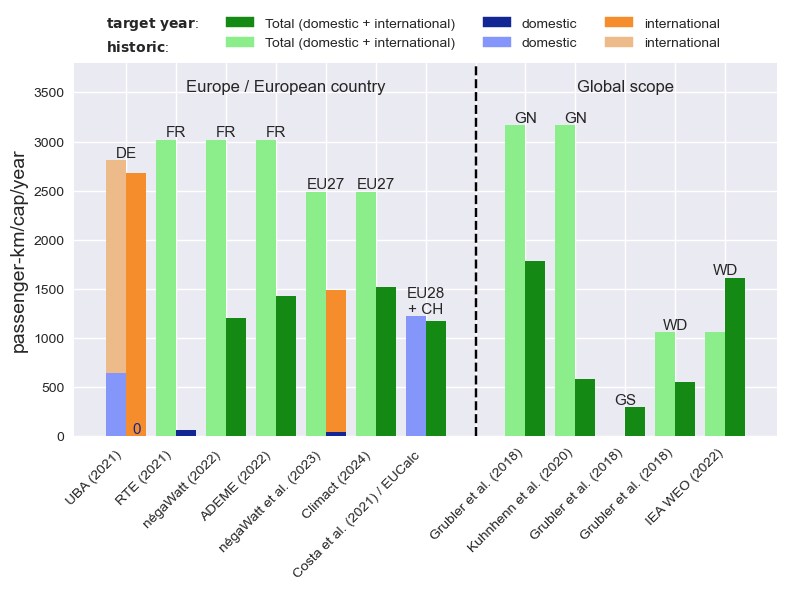

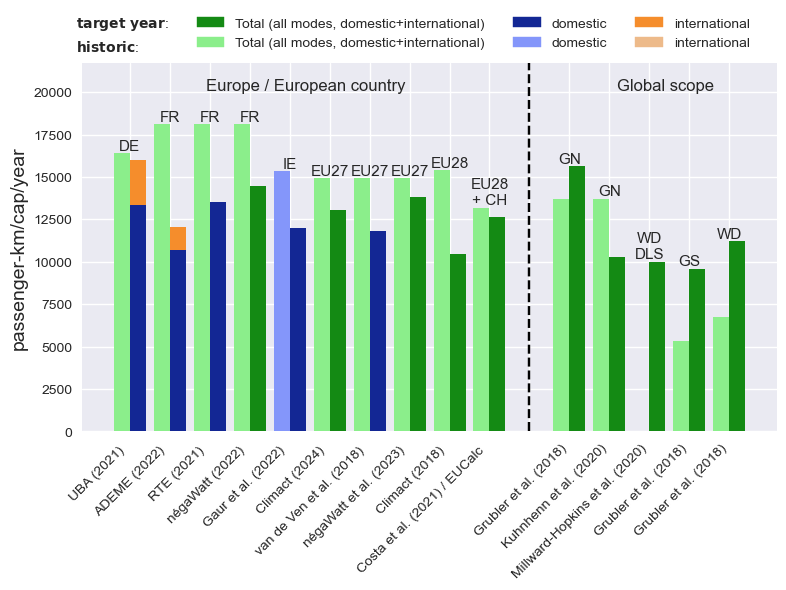

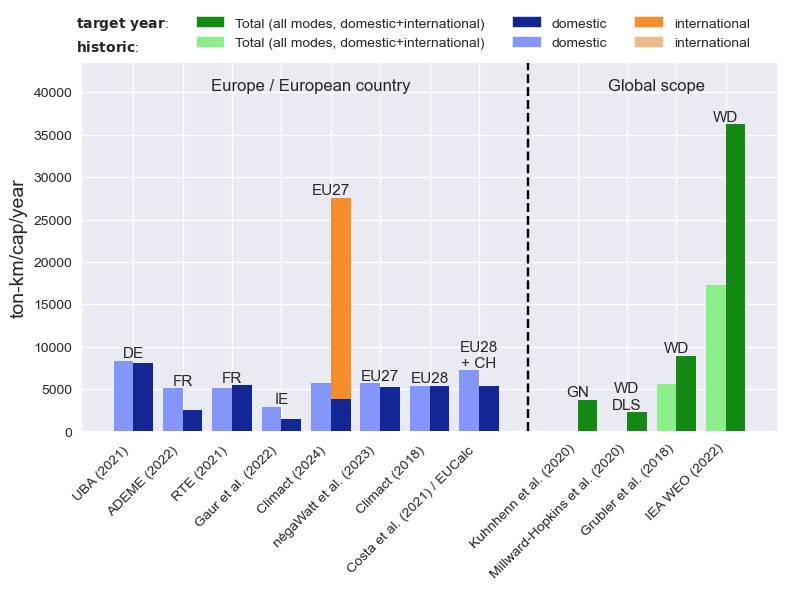

In [15]:
######################
# new


uniform_fontsize = 12
def make_traffic_plots(data, filename, extension=False, standard=False,
                          show_extra_bars=True, show_scope=True, 
                          plot_individual=False, show_historic=True):
    '''
    Function to make the traffic plots
    '''
    plt.style.use('seaborn-v0_8')
    
    # Check for the boolean standard, which indicates if the given data is already 
    # filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators including only the mobility ones
    main_indicators = get_main_indicators(analysis_standard_df, split=True)[0]

    # Create Dataframe for exporting the data as excel file
    export_df = pd.DataFrame()
    
    # Iterate over the indicators and make a plot for each indicator
    for i, indicator in enumerate(main_indicators):

        # Define the figure and axis
        fig, ax = plt.subplots(1)
    
        # Get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator]\
                            .copy().reset_index()
        
        # Select only the needed columns
        indicator_data = indicator_data[['Source', 
                                         'Source+geogr. scope',
                                         'Geographic scope', 
                                         'Scenario (name/historic/DLS)', 
                                         'Sector',
                                         'Main comparison parameter',
                                         'Parameter',
                                         'Unit',
                                         'Value']]
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data.loc[:, 'Historic'] = np.nan

        # Add a column to identify the additional data
        indicator_data.loc[:, 'Additional Data'] = False
       
        # Sort the data by the value (From lowest to highest)
        indicator_data = indicator_data.sort_values('Value').reset_index()

        # Get the historic data for the current indicator and each scenario
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator, groups=True)

        # Sort the data by the geographic scope, therefore assign a rank to each scope
        scope_order_list = ['DE', 'FR', 'IE', 'UK', 'EU', 'EU27', 'EU28', 'EU28+CH', 'Europe+UA']
        indicator_data['scope_rank'] = indicator_data['Geographic scope'].apply(lambda x: scope_order_list.index(x))
        indicator_data = indicator_data.sort_values(by=['scope_rank', 'Value'])

        # Get unique sources for the x-axis
        scenario_sources = list(indicator_data['Source+geogr. scope'].unique())

        # Get the Groups for the indicator_data
        indicator_data = get_groups(indicator_data, indicator)

        # Export the data as excel file if wanted
        if i == 0:
            export_df = indicator_data.copy()
        else:
            export_df = pd.concat([export_df, indicator_data], ignore_index=True)

        # get all groups for the legend, excluding "without active"
        groups_scenario = np.union1d(indicator_data['Group'].unique(), indicator_data['Historic_Group'].unique())
        groups_scenario = groups_scenario[groups_scenario != 'without active']  # Remove "without active"
        
        # Assign each unique source a x-position (needed for stacked plots)
        indicator_data['x_position'] = indicator_data['Source+geogr. scope'].apply(lambda x: scenario_sources.index(x))

        # Plot the scenario values
        ax = plot_traffic_bars(ax, indicator_data, 'target year', 'Value', 'Group')

        # If wanted, plot also the historic values as bars
        if show_historic:    
            ax = plot_traffic_bars(ax, indicator_data, 'historic', 'Historic', 'Historic_Group')

        # Else plot historic line
        else:
            line_hist = ax.axhline(y=indicator_data['Historic'].values[0], 
                                    color='black', linestyle='--', 
                                    label='historic') 
        
        # If the Scope should be shown, write the scope over each bar
        if show_scope:

            # Get the maximum values for each x-position
            max_values_scenarios = indicator_data.groupby('x_position', as_index=False).agg({'Value':'max', 
                                                                                   'Historic':'max', 
                                                                                   'Geographic scope':'first'}).copy()
            # Place the Scope over each bar
            for i, row in max_values_scenarios.iterrows():
                scope = row['Geographic scope']
                if scope.find('+') != -1:
                    scope = scope.split('+')[0] + '\n+ ' + scope.split('+')[1]
                ax.text(row['x_position'], max(row['Value'], row['Historic']), r'{}'.format(scope), ha='center', va='bottom')

        # Get the naming for the x-ticks. Need to be the source without the scope
        x_ticks = [scenario_sources.split('-')[0] for scenario_sources in scenario_sources]
        
        # If the extra bars should be shown get the data for the extra bars
        if show_extra_bars:

            # Define Sources for the additional data
            sources_add =  ['Grubler et al. (2018)', 
                        'Millward-Hopkins et al. (2020)', 
                        'IEA WEO (2022)', 
                        'Kuhnhenn et al. (2020)']
            
            # Get the additional data
            add_data = get_additional_data(data, indicator, sources_add)

            # Remove historic data for Milward Hopkins
            add_data.loc[add_data[add_data['Geographic scope'] == 'WD-DLS'].index, 'Historic'] = np.nan

            # Convert the Value to numeric
            add_data['Historic'] = pd.to_numeric(add_data['Historic'], errors='coerce')
            add_data['Value'] = pd.to_numeric(add_data['Value'], errors='coerce')

            # Get the groups for the additional data
            add_data = get_groups(add_data, indicator, add_data_bool=True)

            # Get all groups in the additional data (historic and scenario), excluding "without active"
            groups_add = np.union1d(add_data['Group'].unique(), add_data['Historic_Group'].unique())
            groups_add = groups_add[groups_add != 'without active']  # Remove "without active"

            # Make a vertical line to separate the extra plots. Therefore append an empty string to the x_ticks
            x_ticks.append('')
            x_offset = len(x_ticks) - 1
            ax.axvline(x_offset, color='#030303', linestyle='--')
            
            x_offset += 1

            # Sort the scenarios by the geographic scope and the value
            def sort_scenarios(x):
                if 'GN' in x:
                    return 0
                elif 'DLS' in x:
                    return 1
                else:
                    return 2

            # Sort the data by the geographic scope, therefore assign a rank 0 to all scopes containing GN and all others 1
            add_data['scope_rank'] = add_data['Geographic scope'].apply(sort_scenarios)

            # Sort the data by the scope, source and value (From lowest to highest)
            add_data = add_data.sort_values(['scope_rank', 'Source', 'Value']).reset_index()

            # Drop the rank column again
            add_data = add_data.drop(columns=['scope_rank'])

            # Get unique sources for the x-axis
            add_data_sources = list(add_data['Source+geogr. scope'].unique())

            # Assign each unique source a x-position (needed for stacked plots)
            add_data['x_position'] = add_data['Source+geogr. scope'].apply(lambda x: x_offset + add_data_sources.index(x))

            # Add the additional data to the export dataframe
            export_df = pd.concat([export_df, add_data], ignore_index=True)

            # Plot the scenario values of the additional data
            ax = plot_traffic_bars(ax, add_data, 'target year', 'Value', 'Group')

            # Plot the historic values of the additional data
            if show_historic:    
                ax = plot_traffic_bars(ax, add_data, 'historic', 'Historic', 'Historic_Group')
            
            # Get the y position for the scope
            max_values_add = add_data.groupby('x_position', as_index=False).agg({'Value':'max', 
                                                                                   'Historic':'max', 
                                                                                   'Geographic scope':'first'}).copy()
            # Place the Scope over each bar
            for i, row in max_values_add.iterrows():
                scope = row['Geographic scope'].replace('-', '\n')   
                ax.text(row['x_position'], max(row['Value'], row['Historic']), r'{}'.format(scope), ha='center', va='bottom')
            
            # Add the sources to the x_ticks for labeling the x axis
            x_ticks_add = [add_data[add_data['Source+geogr. scope'] == x]['Source'].values[0] for x in add_data_sources]
            x_ticks += x_ticks_add
            
            # Get all groups for the legend, combining scenario and historic groups
            groups = np.union1d(groups_scenario, groups_add)

            # Define the patches (Label, Color) for the legend, excluding "without active"
            patches_scenario = [mpatches.Patch(color=colors_traffic['target year'][x], label=x) for x in groups]
            patches_historic = [mpatches.Patch(color=colors_traffic['historic'][x], label=x) for x in groups]
            
            # Reorder the patches for the legend
            patches = [patches_scenario[i//2] if i % 2 == 0 else patches_historic[(i-1)//2] for i in range(2*len(patches_scenario))]
            
            # Insert empty patches as naming for the row of the legend
            patches.insert(0, (mpatches.Patch(color='white', label= r"$\bf{target\ year}$:")))
            patches.insert(1, (mpatches.Patch(color='white', label= r'$\bf{historic}$:')))
            
            #
            fig.legend(handles=patches, loc='upper center', ncols = len(patches)//2, bbox_to_anchor = (0, 0.08, 1, 1))

                
        else:
            # Define the patches (Label, Color) for the legend, excluding "without active"
            patches_scenario = [mpatches.Patch(color=colors_traffic['target year'][x], label=x) for x in colors_traffic['target year'].keys() if x != 'without active']
            patches_historic = [mpatches.Patch(color=colors_traffic['historic'][x], label=x) for x in colors_traffic['historic'].keys() if x != 'without active']
            
            # Reorder the patches for the legend
            patches = [patches_scenario[i//2] if i % 2 == 0 else patches_historic[(i-1)//2] for i in range(2*len(patches_scenario))]
            
            # Insert empty patches as naming for the row of the legend
            patches.insert(0, (mpatches.Patch(color='white', label= r"$\bf{target\ year}$:")))
            patches.insert(1, (mpatches.Patch(color='white', label= r'$\bf{historic}$:')))

            # Add the Legend
            fig.legend(handles=patches, loc='upper center', ncols = len(patches)//2, bbox_to_anchor = (0, 0.08, 1, 1))

        # Configure plot
        ax.set_ylabel(indicator_data['Unit'].values[0], fontsize = 14)
        ax.set_xticks(np.arange(len(x_ticks)), x_ticks, rotation=45, ha="right")
        
        # Change the y-axis label: only change from "pkm" to "Passenger km", keep "tkm" unchanged
        if 'pkm' in indicator_data['Unit'].values[0]:
            ax.set_ylabel("passenger-km/cap/year", fontsize=14)
        else:
            ax.set_ylabel("ton-km/cap/year", fontsize=14)
        
        # Get the maximum Value of the bar plot to set the limit a bit higher than the max value
        if show_scope:
            max_value = max(max_values_scenarios[['Value', 'Historic']].max(axis=1).max(), 
                            max_values_add[['Value', 'Historic']].max(axis=1).max())
        else:
            max_value = indicator_data[['Value', 'Historic']].max(axis=1).max()
        ax.set_ylim(0, max_value* 1.2)

        ######################
        # Calculate positions for the labels
        left_label_x_position = x_offset * 0.4  # Position in the center between 0 and the vertical line
        right_label_x_position = x_offset + len(add_data)*0.4 # Position in the center between the vertical line and the right end of the plot
        print(x_offset)
        print(len(add_data))
        # Add labels for the left and right sides of the dashed line
        ax.text(left_label_x_position, max_value * 1.1, 'Europe / European country', ha='center', va='bottom', fontsize=uniform_fontsize)
        ax.text(right_label_x_position, max_value * 1.1, 'Global scope', ha='center', va='bottom', fontsize=uniform_fontsize)
        ######################

        # If the plots should be saved as individual plots
        if plot_individual:
            
            # Save figure either with default extension or with extension given in the function
            if extension:
                filename = f'{filename}.{extension}'
            
            # Define the naming for the indicator
            if indicator == 'average distance travelled per capita and year':
                indicator_naming = 'Mobility_fig6'
            elif indicator == 'average distance travelled per capita and year | plane':
                indicator_naming = 'Mobility_plane_fig7'
            elif indicator == 'transported goods per capita and year':
                indicator_naming = 'Freight_fig9'

            # Save the figure
            plt.savefig(f'figures/{filename}_{indicator_naming}', bbox_inches="tight")

          
    # Make a nicer look
    plt.tight_layout()
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    
    # Save the figure as png
    plt.savefig(f'figures/{filename}', bbox_inches="tight")
    
    # Rearrange columns for export
    export_df = export_df[['Source', 'Geographic scope', 
                        'Scenario (name/historic/DLS)', 
                        'Sector', 'Parameter', 'Main comparison parameter',
                        'Unit', 'Value', 'Historic',
                        'Historic Source', 'Additional Data', 
                        'Group']]

    # Export the data from the barplot
    export_df.to_excel(f'output/{filename}_mobility_data.xlsx', index=False)

# Call function for making barplots
make_traffic_plots(analysis_df, 'barplot_values', plot_individual=True)


In [16]:
################
# original
'''
uniform_fontsize = 12
def make_traffic_plots(data, filename, extension = False, standard=False,
                          show_extra_bars = True, show_scope = True, 
                          plot_individual = False, show_historic = True):'''
'''
Function to make the traffic plots
:param ax: Axis to plot on
:param indicator: Indicator to plot
:param indicator_data: Data for the indicator
:param data: Data from the Scenario Analysis sheet
:param show_historic: Boolean if the historic values should be shown
:param show_scope: Boolean if the scope should be shown
:param show_extra_bars: Boolean if the extra bars should be shown
:return: Axis with the plot
'''
'''
    plt.style.use('seaborn-v0_8')
    # Check for the boolean standard, which indicates if the given data is already 
    # filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators including only the mobility ones
    main_indicators = get_main_indicators(analysis_standard_df, split = True)[0]

    # Create Dataframe for exporting the data as excel file
    export_df = pd.DataFrame()
    
    # Iterate over the indicators and make a plot for each índicator
    for i, indicator in enumerate(main_indicators):

        # Define the figure and axis
        fig, ax = plt.subplots(1)
    
        # Get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator]\
                            .copy().reset_index()
        
        # Select only the needed columns
        indicator_data = indicator_data[['Source', 
                                         'Source+geogr. scope',
                                         'Geographic scope', 
                                         'Scenario (name/historic/DLS)', 
                                         'Sector',
                                         'Main comparison parameter',
                                         'Parameter',
                                         'Unit',
                                         'Value']]
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data.loc[:, 'Historic'] = np.nan

        # Add a column to identify the additional data
        indicator_data.loc[:, 'Additional Data'] = False
       
        # Sort the data by the value (From lowest to highest)
        indicator_data = indicator_data.sort_values('Value').reset_index()

        # Get the historic data for the current indicator and each scenario
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator, groups=True)

        # Sort the data by the geographic scope, therefore assign a rank to each scope
        scope_order_list = ['DE', 'FR', 'IE', 'UK', 'EU', 'EU27', 'EU28', 'EU28+CH', 'Europe+UA']
        indicator_data['scope_rank'] = indicator_data['Geographic scope'].apply(lambda x: scope_order_list.index(x))
        indicator_data = indicator_data.sort_values(by=['scope_rank', 'Value'])

        # Get unique sources for the x-axis
        scenario_sources = list(indicator_data['Source+geogr. scope'].unique())

        # Get the Groups for the indicator_data
        indicator_data = get_groups(indicator_data, indicator)

        # Export the data as excel file if wanted
        if i == 0:
            export_df = indicator_data.copy()
        else:
            export_df = pd.concat([export_df, indicator_data], ignore_index=True)

        # get all groups for the legend
        groups_scenario = np.union1d(indicator_data['Group'].unique(), indicator_data['Historic_Group'].unique())
        
        # Assign each unique source a x-position (needed for stacked plots)
        indicator_data['x_position'] = indicator_data['Source+geogr. scope'].apply(lambda x: scenario_sources.index(x))

        # Plot the scenario values
        ax = plot_traffic_bars(ax, indicator_data, 'target year', 'Value', 'Group')

        # If wanted plot also the historic values as bars
        if show_historic:    
            ax = plot_traffic_bars(ax, indicator_data, 'historic', 'Historic', 'Historic_Group')

        # Else plot historic line
        else:
            line_hist = ax.axhline(y=indicator_data['Historic'].values[0], 
                                    color='black', linestyle='--', 
                                    label='historic') 
        
        # If the Scope should be shone (Not for Germany only plots), write the scope over each bar
        if show_scope:

            # Get the maximum values for each x-position
            max_values_scenarios = indicator_data.groupby('x_position', as_index=False).agg({'Value':'max', 
                                                                                   'Historic':'max', 
                                                                                   'Geographic scope':'first'}).copy()
            # Place the Scope over each bar
            for i, row in max_values_scenarios.iterrows():
                scope = row['Geographic scope']
                if scope.find('+') != -1:
                    scope = scope.split('+')[0] + '\n+ ' + scope.split('+')[1]
                ax.text(row['x_position'], max(row['Value'], row['Historic']), r'{}'.format(scope), ha='center', va='bottom')

        # Get the naming for the x-ticks. Need to be the source without the scope
        x_ticks = [scenario_sources.split('-')[0] for scenario_sources in scenario_sources]
        
        # If the extra bars should be shown get the data for the extra bars
        if show_extra_bars:

            # Define Sources for the additional data
            sources_add =  ['Grubler et al. (2018)', 
                        'Millward-Hopkins et al. (2020)', 
                        'IEA WEO (2022)', 
                        'Kuhnhenn et al. (2020)']
            
            # Get the additional data
            add_data = get_additional_data(data, indicator, sources_add)

            # Remove historic data for Milward Hopkins
            add_data.loc[add_data[add_data['Geographic scope'] == 'WD-DLS'].index, 'Historic'] = np.nan

            # Convert the Value to numeric
            add_data['Historic'] = pd.to_numeric(add_data['Historic'], errors='coerce')
            add_data['Value'] = pd.to_numeric(add_data['Value'], errors='coerce')

            # Get the groups for the additional data
            add_data = get_groups(add_data, indicator, add_data_bool=True)

            # Get all groups in the additional data (historic and scenario)
            groups_add = np.union1d(add_data['Group'].unique(), add_data['Historic_Group'].unique())

            # Make a vertical line to seperate the extra plots. Therefor append an empty string to the x_ticks
            x_ticks.append('')
            x_offset = len(x_ticks) - 1
            ax.axvline(x_offset, color='#030303', linestyle='--')
            x_offset += 1

            # Sort the scenarios by the geographic scope and the value
            def sort_scenarios(x):
                if 'GN' in x:
                    return 0
                elif 'DLS' in x:
                    return 1
                else:
                    return 2

            # Sort the data by the geographic scope, therefore assign a rank 0 to all scopes containing GN and all others 1
            add_data['scope_rank'] = add_data['Geographic scope'].apply(sort_scenarios)

            # Sort the data by the scope, source and value (From lowest to highest)
            add_data = add_data.sort_values(['scope_rank', 'Source', 'Value']).reset_index()

            # Drop the rank column again
            add_data = add_data.drop(columns=['scope_rank'])

            # Get unique sources for the x-axis
            add_data_sources = list(add_data['Source+geogr. scope'].unique())

            # Assign each unique source a x-position (needed for stacked plots)
            add_data['x_position'] = add_data['Source+geogr. scope'].apply(lambda x: x_offset + add_data_sources.index(x))

            # Add the additional data to the export dataframe
            export_df = pd.concat([export_df, add_data], ignore_index=True)

            # Plot the scenario values of the additional data
            ax = plot_traffic_bars(ax, add_data, 'target year', 'Value', 'Group')

            # Plot the historic values of the additional data
            if show_historic:    
                ax = plot_traffic_bars(ax, add_data, 'historic', 'Historic', 'Historic_Group')
            
            # Get the y position for the scope
            max_values_add = add_data.groupby('x_position', as_index=False).agg({'Value':'max', 
                                                                                   'Historic':'max', 
                                                                                   'Geographic scope':'first'}).copy()
            # Place the Scope over each bar
            for i, row in max_values_add.iterrows():
                scope = row['Geographic scope'].replace('-', '\n')   
                ax.text(row['x_position'], max(row['Value'], row['Historic']), r'{}'.format(scope), ha='center', va='bottom')
            
            # Add the sources to the x_ticks for labeling the x axis
            x_ticks_add = [add_data[add_data['Source+geogr. scope'] == x]['Source'].values[0] for x in add_data_sources]
            x_ticks += x_ticks_add
            
            # Get all groups for the legend
            groups = np.union1d(groups_scenario, groups_add)

            # Define the patches (Label, Color) for the legend
            patches_scenario = [mpatches.Patch(color=colors_traffic['target year'][x], label=x) for x in groups]
            patches_historic = [mpatches.Patch(color=colors_traffic['historic'][x], label=x) for x in groups]
            
            # Reorder the patches for the legend
            patches = [patches_scenario[i//2] if i % 2 == 0 else patches_historic[(i-1)//2] for i in range(2*len(patches_scenario))]
            
            # Insert empty patches as naming for the row of the legend
            patches.insert(0, (mpatches.Patch(color='white', label= r"$\bf{scenario  2045/50}$:")))
            patches.insert(1, (mpatches.Patch(color='white', label= r'$\bf{historic}$:')))
            
            #
            fig.legend(handles=patches, loc='upper center', ncols = len(patches)//2, bbox_to_anchor = (0, 0.08, 1, 1))

                
        else:
            # Define the patches (Label, Color) for the legend
            patches_scenario = [mpatches.Patch(color=colors_traffic['target year'][x], label=x) for x in colors_traffic['target year'].keys()]
            patches_historic = [mpatches.Patch(color=colors_traffic['historic'][x], label=x) for x in colors_traffic['historic'].keys()]
            
            # Reorder the patches for the legend
            patches = [patches_scenario[i//2] if i % 2 == 0 else patches_historic[(i-1)//2] for i in range(2*len(patches_scenario))]
            
            # Insert empty patches as naming for the row of the legend
            patches.insert(0, (mpatches.Patch(color='white', label= r'$\bf{scenario  2045/50}$:')))
            patches.insert(1, (mpatches.Patch(color='white', label= r'$\bf{historic}$:')))

            # Add the Legend
            fig.legend(handles=patches, loc='upper center', ncols = len(patches)//2, bbox_to_anchor = (0, 0.08, 1, 1))

        # Configure plot
        # ax.set_title(f'{indicator}')
        ax.set_ylabel(indicator_data['Unit'].values[0])
        ax.set_xticks(np.arange(len(x_ticks)),x_ticks, rotation=45, ha="right")
        ############################################################################################################
        # Change the y-axis label: only change from "pkm" to "Passenger km", keep "tkm" unchanged
        if 'pkm' in indicator_data['Unit'].values[0]:
            ax.set_ylabel("Passenger-km/cap/year", fontsize=uniform_fontsize)
        else:
            ax.set_ylabel("Ton-km/cap/year", fontsize=uniform_fontsize)
        ############################################################################################################
        # Get the maximum Value of the bar plot to set the limit a bit higher than the max value
        if show_scope:
            max_value = max(max_values_scenarios[['Value', 'Historic']].max(axis=1).max(), 
                            max_values_add[['Value', 'Historic']].max(axis=1).max())
        else:
            max_value = indicator_data[['Value', 'Historic']].max(axis=1).max()
        ax.set_ylim(0, max_value* 1.2)

        # If the plots should be saved as individual plots
        if plot_individual:
            
            # Save figure either with default extension or with extension given in the function
            if extension:
                filename = f'{filename}.{extension}'
            
            # Define the naming for the indicator
            if indicator == 'average distance travelled per capita and year':
                indicator_naming = 'Mobility'
            elif indicator == 'average distance travelled per capita and year | plane':
                indicator_naming = 'Mobility_plane'
            elif indicator == 'transported goods per capita and year':
                indicator_naming = 'Freight'

            # Save the figure
            plt.savefig(f'figures/{filename}_{indicator_naming}', bbox_inches = "tight")

    # Make a nicer look
    plt.tight_layout()
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    
    # Save the figure as png
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")
    
    # rearange columns for export
    export_df = export_df[['Source', 'Geographic scope', 
                        'Scenario (name/historic/DLS)', 
                        'Sector', 'Parameter', 'Main comparison parameter',
                        'Unit', 'Value', 'Historic',
                        'Historic Source', 'Additional Data', 
                        'Group']]

    # Export the data from the barplot
    export_df.to_excel(f'output/{filename}_mobility_data.xlsx', index=False)

# Call function for making barplots
make_traffic_plots(analysis_df, 'barplot_values', plot_individual=True)'''

'\n    plt.style.use(\'seaborn-v0_8\')\n    # Check for the boolean standard, which indicates if the given data is already \n    # filtered after standard scenarios or if it has to be done\n    if not standard:\n        analysis_standard_df = get_standard_scenarios(data, scenarios_df)\n    else:\n        analysis_standard_df = data\n\n    # Get the main indicators including only the mobility ones\n    main_indicators = get_main_indicators(analysis_standard_df, split = True)[0]\n\n    # Create Dataframe for exporting the data as excel file\n    export_df = pd.DataFrame()\n    \n    # Iterate over the indicators and make a plot for each índicator\n    for i, indicator in enumerate(main_indicators):\n\n        # Define the figure and axis\n        fig, ax = plt.subplots(1)\n    \n        # Get the data for the current indicator\n        indicator_data = analysis_standard_df[analysis_standard_df[\'Main comparison parameter\'] == indicator]                            .copy().reset_index()\n

##### 3.1.2 Non-Mobility Barplots
Now we make a barplot for each sector in the Non-Mobility indicators. Please notice that the indicator _average distance travelled per capita and year | car_ also is in the Non-Mobility indicators, because we do not have the seperation into groups (international, domestic, etc.). 

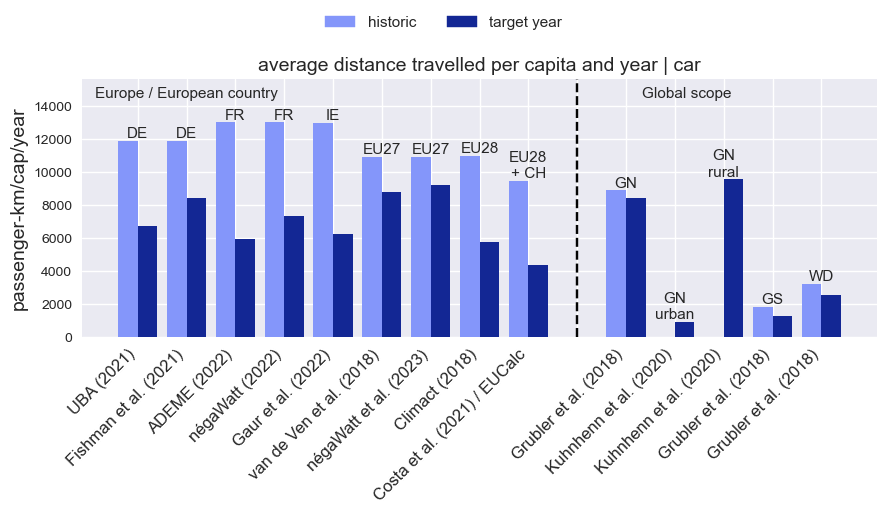

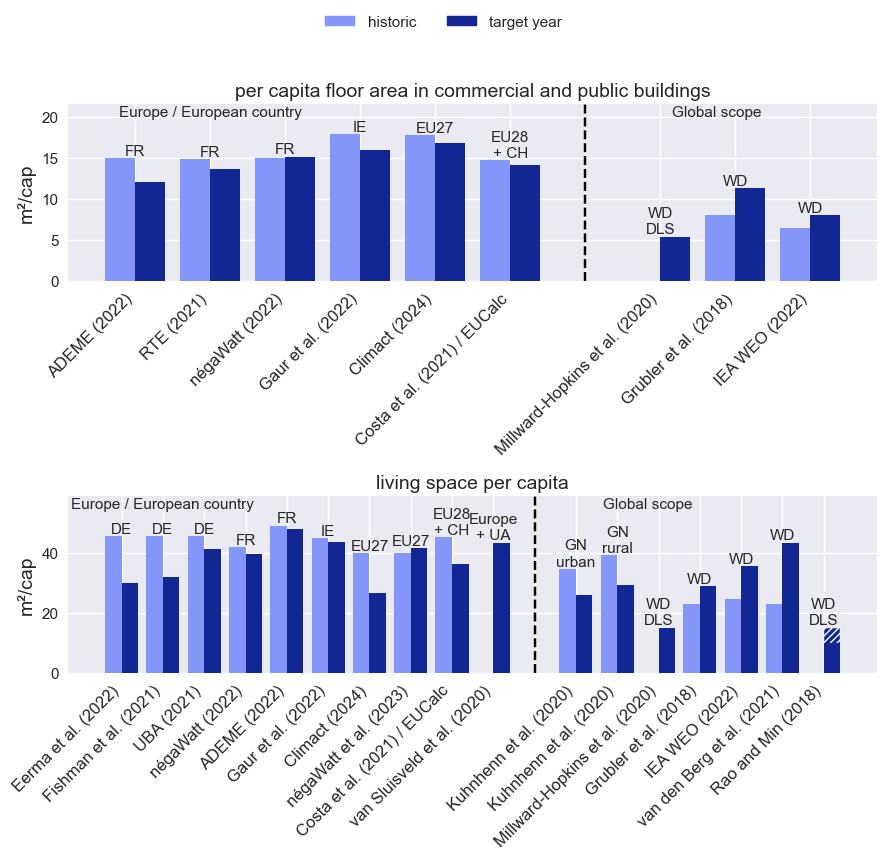

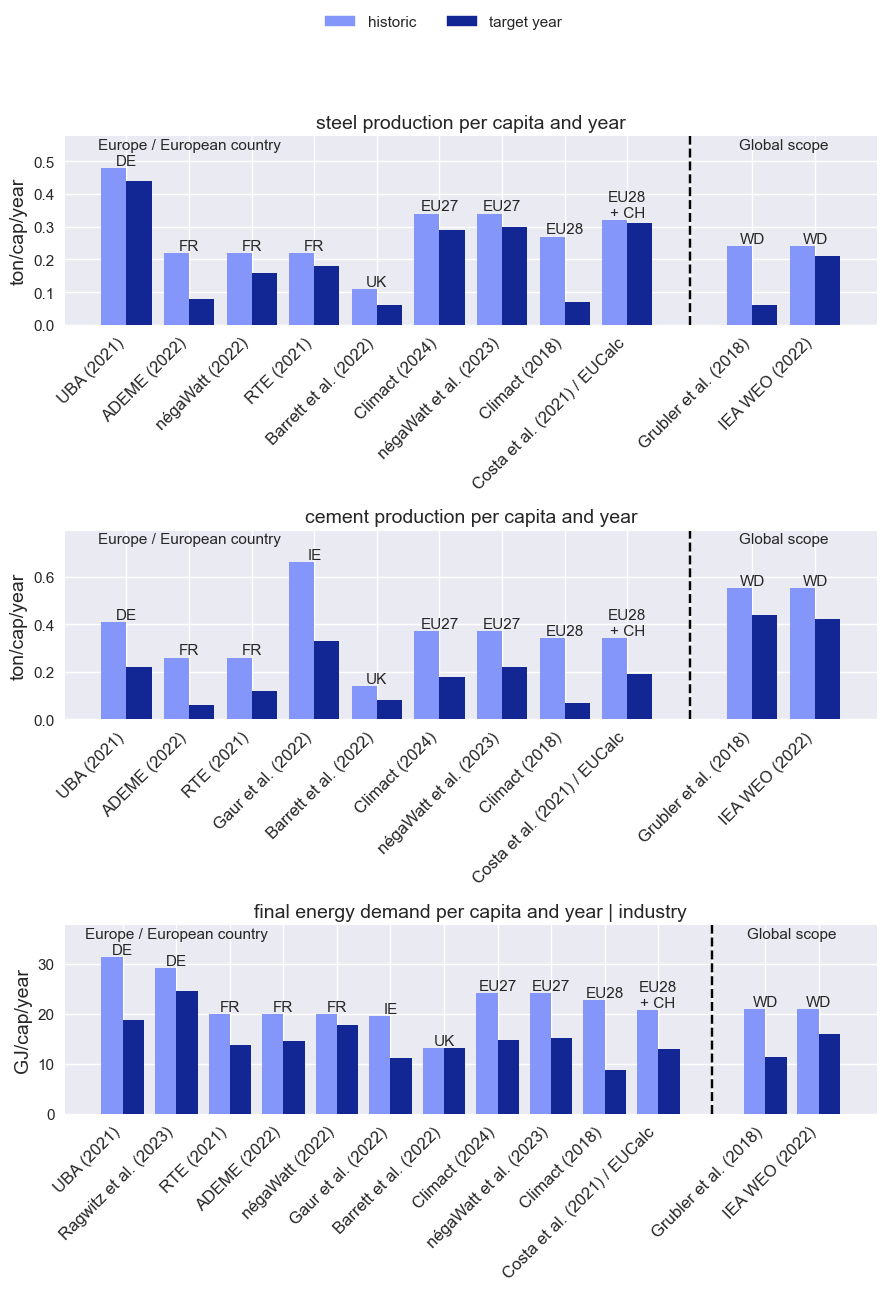

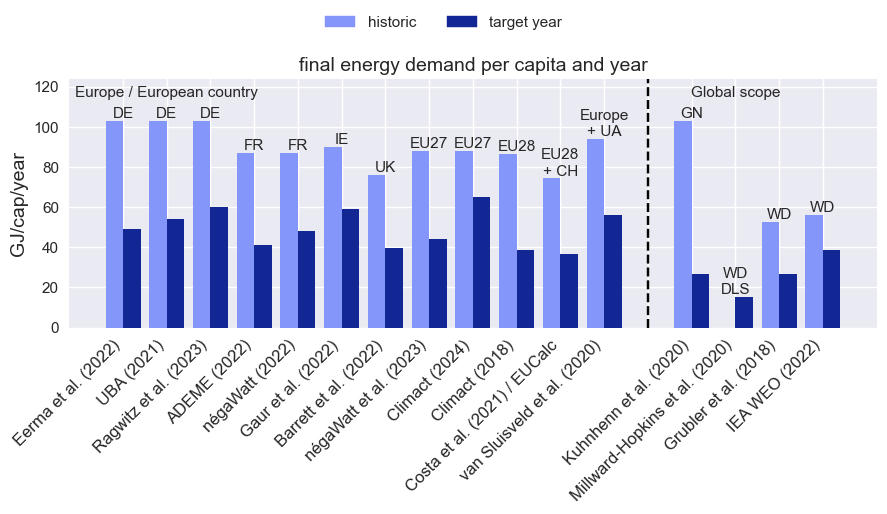

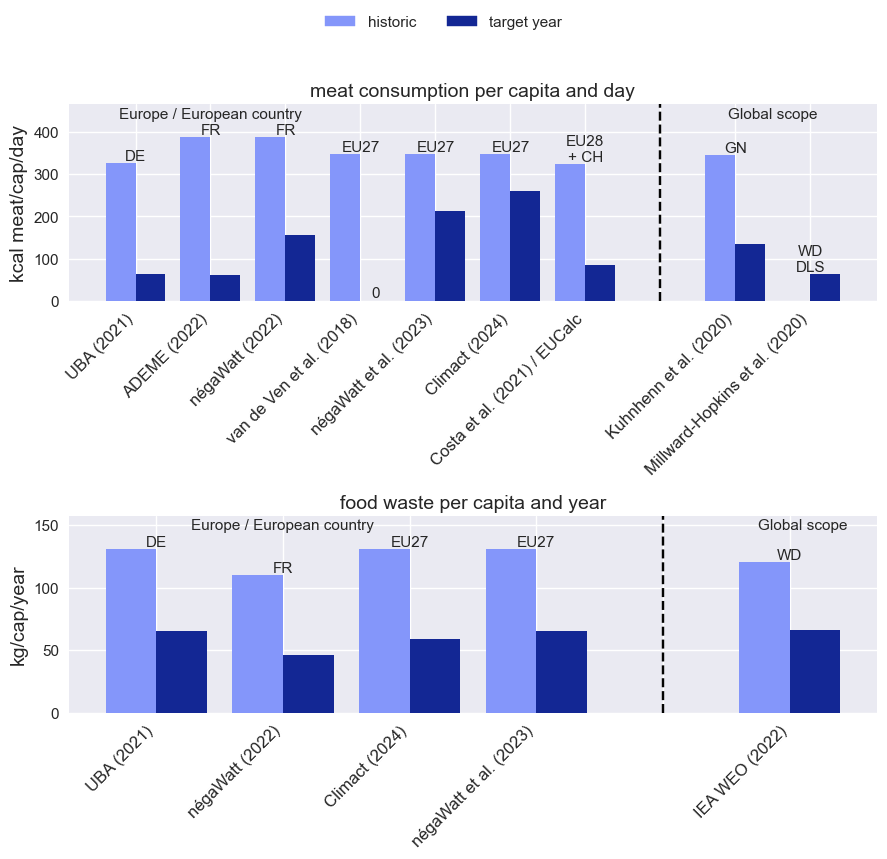

In [17]:
######################
# original
######################
def make_barplot_multiple(data, filename, extension = False, standard=False,
                          show_extra_bars = True, show_scope = True, 
                          plot_individual = False, show_historic = True):
    '''
    Function to make a barplot of the values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param show_extra_bars: Boolean if extra bars should be shown
    :param show_scope: Boolean if the scope should be shown
    :param plot_individual: Boolean if the plot should be saved as individual plots
    :return: None
    '''
    uniform_fontsize = 11

    # Check for the boolean standard, which indicates if the given data is already 
    # filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
    
    # Get all main indicators related to non-mobility
    main_indicators = get_main_indicators(analysis_standard_df, split = True)[1]

    # filter out the main indicators related to mobility
    analysis_standard_df =  analysis_standard_df[analysis_standard_df['Main comparison parameter'].isin(main_indicators)]

    # Check if the plot should be saved as individual plots for each sector
    if plot_sectors:

        # Get the sectors for the main indicators
        analysis_standard_df['Sector'] =  analysis_standard_df['Main comparison parameter']\
                                                        .apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector']\
                                                        .values[0])
        # Get the unique sectors
        sectors = analysis_standard_df['Sector'].unique()
    
    else:
        # 'All' is a dummy sector to plot all comparison parameters and only do one loop in the for loop
        sectors = ['All']

    # Create Dataframe for exporting the data as excel file
        export_df = pd.DataFrame()
        
    # Iterate over the sectors and make a plot for each sector
    for j, sector in enumerate(sectors):
        #------------------------------------------------------------------------------
        # Check if a plot per sector should be made and get main indicators for the sector
        if plot_sectors:

            # Get the main indicators for the current sector
            main_indicators = analysis_standard_df[analysis_standard_df['Sector'] == sector]['Main comparison parameter'].unique()
            
            # Get the number of main indicators for the current sector
            amt_main_indicators = len(main_indicators)

            # Calculate current row and column for a given amount of main indicators
            if amt_main_indicators == 1:
                fig, axs = plt.subplots(1, figsize=(9,4.8))
                updated_fontsize = 11
            elif amt_main_indicators == 2:
                
                #update_font_sizes(small_size=16, medium_size=16, big_size=22)
                updated_fontsize = 11
                fig, axs = plt.subplots(2, 1, figsize=(9,8))

            # Tree plots is a special case, because of the allignment of plots
            elif amt_main_indicators == 3:
                
                #update_font_sizes(small_size=16, medium_size=16, big_size=22)
                updated_fontsize = 11
                fig, axs = plt.subplots(3, 1, figsize=(9,12))

                # #update_font_sizes(small_size=16, medium_size=20, big_size=22)
                # gs = gridspec.GridSpec(2, 2)
                # fig = plt.figure(figsize=(16,8))
                # updated_fontsize = 16

        else:
                fig, ax = plt.subplots(1)
        #------------------------------------------------------------------------------
        
        # Iterate over the indicators and make a plot for each índicator
        for i, indicator in enumerate(main_indicators):

            # Check if the plot should be saved as individual or one plot per sector. If plot per sector, get the axis
            if plot_sectors:
                if amt_main_indicators == 1:
                    ax = axs
                elif amt_main_indicators == 2 or amt_main_indicators == 3:
                    ax = axs[i] 

                # # In the case of three subplots, we need to use the gridspec
                # elif amt_main_indicators == 3:
                #     if i == 0:
                #         ax = fig.add_subplot(gs[0, 0]) 
                #     elif i == 1:
                #         ax = fig.add_subplot(gs[0, 1])
                #     elif i == 2:

                #         # Plot the lower subplot over all columns
                #         ax = fig.add_subplot(gs[1, :])

            # Get the data for the current indicator
            indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator]\
                                .copy().reset_index()
            indicator_data = indicator_data[['Source', 
                                            'Geographic scope', 
                                            'Scenario (name/historic/DLS)', 
                                            'Sector',
                                            'Main comparison parameter',
                                            'Parameter',
                                            'Unit',
                                            'Value']]
            indicator_data["Unit"] = indicator_data["Unit"].apply(lambda x: x.replace('t/cap/year', 'ton/cap/year'))
            idx = indicator_data[indicator_data["Main comparison parameter"] == "per capita floor area in commercial and public buildings"].index
            indicator_data.loc[idx, "Unit"]= "m²/cap"
            indicator_data["Unit"] = indicator_data["Unit"].apply(lambda x: x.replace('pkm/cap/year', 'passenger-km/cap/year'))
            # Change column type to numeric
            indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
            indicator_data['Historic'] = np.nan

            # Add a column to identify the additional data
            indicator_data['Additional Data'] = False

            # Sort the data by the geographic scope, therefore assign a rank to each scope
            scope_order_list = ['DE', 'FR', 'IE', 'UK', 'EU', 'EU27', 'EU28', 'EU28+CH', 'Europe+UA']
            indicator_data['scope_rank'] = indicator_data['Geographic scope'].apply(lambda x: scope_order_list.index(x))

            # Sort the data by the value (From lowest to highest)
            indicator_data = indicator_data.sort_values(['scope_rank', 'Value']).reset_index()

            # Drop the rank column again
            indicator_data = indicator_data.drop(columns=['scope_rank'])

            # Get the historic data for the current indicator and each scenario
            indicator_data = get_historic_values(analysis_df, indicator_data, indicator)

            # Ensure the values for Historic are numeric
            indicator_data['Historic'] = pd.to_numeric(indicator_data['Historic'], errors='coerce')
            
            # Export the data as excel file if wanted
            if j == 0:
                export_df = indicator_data.copy()
            else:
                export_df = pd.concat([export_df, indicator_data], ignore_index=True)

            # Get the x-positions for the bars
            x = np.arange(len(indicator_data))

            # Plot the scenario values
            bar_scenarios = ax.bar(x+0.2, 
                        indicator_data['Value'].values,
                        width = 0.4,
                        color = colors_studies['Europe/European country target year'],
                        label='target year')

            # Add a zero if scenario value is zero
            for zero_index in indicator_data[indicator_data['Value'] == 0].index.values:
                ax.text(zero_index + 0.2, 0.5, '0', ha='center', va='bottom', fontsize = uniform_fontsize)
            
            # If wanted plot also the historic values as bars
            if show_historic:            
                
                # Plot the historic values
                bar_hist = ax.bar(x-0.2, 
                            indicator_data['Historic'].values,
                            width = 0.4,
                            color = colors_studies['Europe/European country historic'],
                            label='historic')

                # Add a zero if historic value is zero
                for zero_index in indicator_data[indicator_data['Historic'] == 0].index.values:
                    ax.text(zero_index - 0.2, 0.5, '0', ha='center', va='bottom', fontsize = uniform_fontsize)
            
            # Else plot historic line
            else:
                line_hist = ax.axhline(y=indicator_data['Historic'].values[0], 
                                    color='black', linestyle='--', 
                                    label='historic') 
            
            # If the Scope should be shone (Not for Germany only plots)
            if show_scope:

                # Write the scope for each scenario over the bars (Over the highest bar between historic and scenario value)
                for k, rect_scen in enumerate(bar_scenarios):

                    # Check if historic values are shown, if yes get the higher bar between historic and scenario value
                    if show_historic:
                        rect_hist = bar_hist[k]
                        height = max(rect_scen.get_height(), rect_hist.get_height())
                    
                    # If no historic values are shown get the height of the scenario value
                    else:
                        height = rect_scen.get_height()
                    
                    # Get the scope of the scenario
                    scope_study = indicator_data.iloc[k]['Geographic scope']
                    
                    # Add a line break if a '+' is in the scopes
                    if scope_study.find('+') != -1:
                        scope_study = scope_study.split('+')[0] + '\n+ ' + scope_study.split('+')[1]
                    
                    # Write the scope over the bar
                    ax.text(rect_scen.get_x(), height, r'{}'.format(scope_study), ha='center', va='bottom', fontsize = uniform_fontsize)

            # Get the naming for the x-ticks
            x_ticks = list(indicator_data['Source'].values)
            
            # If the extra bars should be shown get the data for the extra bars
            if show_extra_bars:

                # Get additional data
                sources =  ['Grubler et al. (2018)', 
                            'Millward-Hopkins et al. (2020)', 
                            'IEA WEO (2022)', 
                            'Kuhnhenn et al. (2020)',
                            'Rao and Min (2018)',
                            'van den Berg et al. (2021)']
                
                # Get the additional data
                add_data = get_additional_data(data, indicator, sources)

                add_data['Historic'] = pd.to_numeric(add_data['Historic'], errors='coerce')
                add_data['Value'] = pd.to_numeric(add_data['Value'], errors='coerce')

                # Mark it as additional data
                add_data['Additional Data'] = True

                # Sort the scenarios by the geographic scope and the value
                def sort_scenarios(row):
                    if row['Source'] == 'Rao and Min (2018)':
                        if row['Value'] > 10:
                            return 3
                        else:
                            return 4
                    else:
                        x = row['Geographic scope']
                        if 'GN' in x:
                            return 0
                        elif 'DLS' in x:
                            return 1
                        else:
                            return 2

                # Sort the data by the geographic scope, therefore assign a rank 0 to all scopes containing GN and all others 1
                add_data['scope_rank'] = add_data.apply(sort_scenarios, axis=1)

                # Sort the data by the scope, source and value (From lowest to highest)
                add_data = add_data.sort_values(['scope_rank', 'Source', 'Value']).reset_index()

                # Drop the rank column again
                add_data = add_data.drop(columns=['scope_rank'])

                # Export the data as excel file if wanted
                export_df = pd.concat([export_df, add_data], ignore_index=True)

                # Make a vertical line to seperate the extra plots
                x_ticks.append('')
                x = len(indicator_data['Source'].values)
                ax.axvline(x, color='#030303', linestyle='--')
                
                x += 1

                # Create new array for x positions of the extra bars
                x_positions = np.arange(x, x + len(add_data))
                
                # If Raon and Min are included, delete last element of x_positions
                # Because the 2 values from the study are shown as stacked values
                if 'Rao and Min (2018)' in add_data['Source'].values:
                    x_positions[-1] -= 1

                # Plot the scenario values
                bar_scenarios = ax.bar(x_positions +0.2, 
                            add_data['Value'].values,
                            width = 0.4,
                            color = colors_studies['other regions/approaches 2045/50'],
                            label='target year')
                
                # Plot the historic values
                bar_hist = ax.bar(x_positions -0.2, 
                            add_data['Historic'].values,
                            width = 0.4,
                            color = colors_studies['other regions/approaches historic'],
                            label='historic')
                
                # Add a zero if scenario value is zero
                for zero_index in add_data[add_data['Historic'] == 0].index.values:
                    ax.text(x + zero_index - 0.2, 0.5, '0', ha='center', va='bottom', fontsize = uniform_fontsize)

                # Give the upper par of the two different studies a different hatch
                if 'Rao and Min (2018)' in add_data['Source'].values:
                    bar_scenarios.patches[-2].set_hatch('/////',)
                    bar_scenarios.patches[-2].set_edgecolor('white')

                # If Raon and Min are included, remove the last element of Dataframe,
                # Because the 2 values from the study are shown as stacked values
                if 'Rao and Min (2018)' in add_data['Source'].values:
                    add_data = add_data[:-1]
                
                # Write the scope for each scenario over the bars 
                # Over the highest bar between historic and scenario value
                for j, row in add_data.iterrows():
                    rect_scen = bar_scenarios[j]
                    rect_hist = bar_hist[j]
                    height = max(rect_scen.get_height(), rect_hist.get_height())
                    scope_study = row['Geographic scope'].replace('-', '\n')
                    ax.text(rect_scen.get_x(), height, r'{}'.format(scope_study), ha='center', va='bottom', fontsize = uniform_fontsize)
                
                # Add the sources to the x_ticks for labeling the x axis
                x_ticks += add_data['Source'].values.tolist()

                # # manually define a new patch 
                # patches = [mpatches.Patch(color=colors_studies[x], label=x) for x in colors_studies.keys()]

                # # plot the legend
                # if i == 0:
                #     fig.legend(handles=patches, loc='upper center', ncols = 2, bbox_to_anchor = (0, 0.08, 1, 1),
                #                 bbox_transform = plt.gcf().transFigure, fontsize = uniform_fontsize)
                ############################################################################################################
                # Define a combined legend with only "historic" and "target year" labels
                patches = [
                    mpatches.Patch(color=colors_studies['Europe/European country historic'], label='historic'),
                    mpatches.Patch(color=colors_studies['Europe/European country target year'], label='target year')
                ]
                
                # Plot the simplified legend
                if i == 0:
                    fig.legend(handles=patches, loc='upper center', ncols=2, bbox_to_anchor=(0, 0.08, 1, 1),
                                    bbox_transform=plt.gcf().transFigure, fontsize=uniform_fontsize)
            else:
                # Get the correct legend without duplicate keys
                handles, labels = ax.get_legend_handles_labels()
                by_label = dict(zip(labels, handles))
                if i == amt_main_indicators - 1:
                    fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncols = 2, bbox_to_anchor = (0, 0.08, 1, 1),
                                bbox_transform = plt.gcf().transFigure, fontsize = uniform_fontsize)

            # Configure plot
            ax.set_title(f'{indicator}', fontsize = 14)
            ax.set_ylabel(indicator_data['Unit'].values[0], fontsize = 14)
            ax.set_xticks(np.arange(len(x_ticks)),x_ticks, rotation=45, ha="right", fontsize = 12)

            # Get the maximum Value of the bar plot to set the limit a bit higher than the max value
            # Get the y position for the scope        
            max_value = max([x.get_height() for x in ax.patches])
            ax.set_ylim(0, max_value* 1.2)
            # Add labels for the left and right sides of the dashed line
            # Calculate positions for the labels
            left_label_x_position = 1  # Position in the center between 0 and the vertical line
            if len(add_data) < 2:
                right_label_x_position = x + 0.1
            else:
                right_label_x_position = x + len(add_data)*0.25 # Position in the center between the vertical line and the right end of the plot
            
            # Add labels for the left and right sides of the dashed line
            ax.text(left_label_x_position, max_value * 1.1, 'Europe / European country', ha='center', va='bottom', fontsize=updated_fontsize)
            ax.text(right_label_x_position, max_value * 1.1, 'Global scope', ha='center', va='bottom', fontsize=updated_fontsize)
            
            # Check if the plots should be saved as individual plots
            if not plot_sectors:
                
                # Save figure either with default extension or with extension given in the function
                if extension:
                    filename = f'{filename}.{extension}'
                
                # Save the figure as png
                indicator_naming = indicator.replace('|', '')
                plt.savefig(f'figures/{filename}_{indicator_naming}', bbox_inches = "tight")

        # Make a nicer look
        plt.tight_layout()
        
        # Save figure either with default extension or with extension given in the function
        if extension:
            filename = f'{filename}.{extension}'

        # Define the naming for the sector Mobility
        if sector == 'Mobility':
            sector = 'Mobility_car'
        
        # Save the figure as png
        plt.savefig(f'figures/{filename}_{sector}', bbox_inches = "tight")
        
        # rearange columns for export
        export_df = export_df[['Source', 'Geographic scope', 
                            'Scenario (name/historic/DLS)', 
                            'Sector', 'Parameter', 'Main comparison parameter',
                            'Unit', 'Value', 'Historic',
                            'Historic Source', 'Additional Data']]

        # Export the data from the barplot
        export_df.to_excel(f'output/{filename}_data.xlsx', index=False)
        
        # reset font sizes
        # update_font_sizes()
        plt.rcParams.update({
        'font.size': uniform_fontsize,
        'axes.titlesize': uniform_fontsize,
        'axes.labelsize': uniform_fontsize,
        'xtick.labelsize': uniform_fontsize,
        'ytick.labelsize': uniform_fontsize,
        'legend.fontsize': uniform_fontsize,
        'text.usetex': False  # If needed for LaTeX formatting
    })

# Call function for making barplots
plot_sectors = True
make_barplot_multiple(analysis_df, 'barplot_values', plot_individual=False)

In [18]:
analysis_df[analysis_df.Source == 'Ragwitz et al. (2023)']
data = analysis_df.copy()
analysis_standard_df = get_standard_scenarios(data, scenarios_df)

In [19]:
analysis_standard_df[analysis_standard_df.Source == 'Ragwitz et al. (2023)']


,Source,Geographic scope,Source+geogr. scope,Scenario (name/historic/DLS),Sector,Parameter,Main comparison parameter,Coding,Year,Unit,Value,Input/Output,Model/Source/DLS,"Original value, combined value, calculated",Comment,Name who inserted it
437,Ragwitz et al. (2023),DE,Ragwitz et al. (2023) - DE,Nachfrage+Tech,Industry,Final Energy Demand | Industry,final energy demand per capita and year | indu...,1,2045.0,GJ/cap/year,24.47,NaN,NaN,NaN,NaN,Mirko
438,Ragwitz et al. (2023),DE,Ragwitz et al. (2023) - DE,Nachfrage+Tech,Energy,Final Energy Demand,final energy demand per capita and year,1,2045.0,GJ/cap/year,60.08,NaN,NaN,NaN,NaN,Mirko


#### 3.2 Make Boxplots
Now we make boxplots for different comparisons, which means the scenario values are compared to _median, dls_ and _historic_ values. Therefore we first define a function which exports the boxplot data as excel file. 

In [20]:
def create_result_table_boxplot(indicator_table_data, filename, extra_columns=[], ):
    '''
    Function to create a result table corresponding to the plot containing all Datapoints
    :param indicator_table_data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extra_columns: List of extra columns to be added to the result table
    :return: None
    '''
    # Define the columns to be included in the result table
    wanted_columns = ['Source', 'Geographic scope', 
                      'Scenario (name/historic/DLS)', 
                      'Sector', 'Main comparison parameter', 
                      'Year', 'Unit', 'Value'] + extra_columns
    
    # Get the data for the result table
    table_data = indicator_table_data[wanted_columns].copy()

    # Add the column 'Zeile im Spreadsheet' to the result table
    table_data['Zeile im Spreadsheet'] = table_data.index + 1

    # Export the data as excel file
    table_data.to_excel(f'output/{filename}.xlsx', index=False)


##### 3.2.1 Boxplot of Values

To show the variance in the indicators, make a boxplot for each indicator, where the relative change to the median is shown. For the Mobilty values we need a function to get the scenario value, which is international + domestic for the indicators _average distance_ and _average distance | plane_. For the indicator _transported goods_ we only take the domestic values.

In [21]:
def get_values_mobility(indicator_data, indicator):

    # Assign the groups for the data (default is domestic)
    indicator_data['Group'] = 'domestic'
    indicator_data.loc[indicator_data['Parameter'].str.contains('international'), 'Group'] = 'international'

    # Make the legend for each indicator
    indicator_data = indicator_data.assign(
        Group = indicator_data.groupby('Source+geogr. scope').Group\
            .transform(lambda x: 'Total (domestic + international)' if 'domestic' not in x.values else x),
    )   

    #indicator_data = indicator_data.sort_values(['Source+geogr. scope', 'Group'], ascending=[True, False])
    if indicator == 'average distance travelled per capita and year | plane' or indicator == 'average distance travelled per capita and year':
        indicator_data = indicator_data.groupby(['Source+geogr. scope']).agg({
            'Value':'max', 'Group':'sum',
            'Source':'first', 'Geographic scope':'first',
            'Scenario (name/historic/DLS)':'first',
            'Sector':'first', 'Main comparison parameter':'first',
            'Year':'first', 'Unit':'first'}).reset_index()

        indicator_data['Group'] = indicator_data['Group'].apply(lambda x: 'Total (domestic + international)' if 'international' in x else x)

    # Get the Groups for the indicator_data
    #indicator_data = get_groups(indicator_data, indicator)
    
    if indicator == 'average distance travelled per capita and year | plane':
        indicator_data = indicator_data[indicator_data['Group'] == 'Total (domestic + international)']
        return indicator_data
    elif indicator == 'average distance travelled per capita and year':
        indicator_data = indicator_data[indicator_data['Group'] == 'Total (domestic + international)']
        return indicator_data
    elif indicator == 'transported goods per capita and year':
        indicator_data = indicator_data[indicator_data['Group'] == 'domestic']
        return indicator_data
    else:
        return indicator_data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


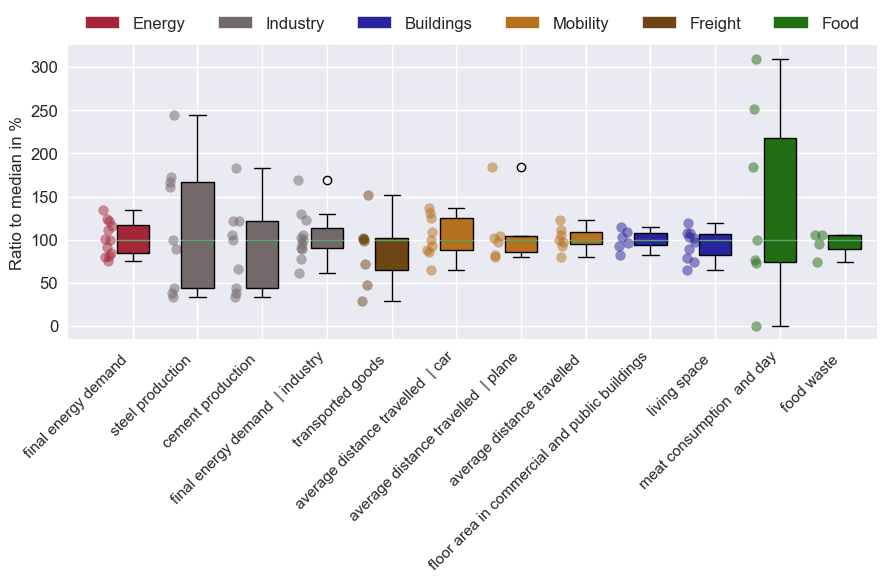

In [36]:
def make_boxplot_median(data, filename, extension = False, standard=False):
    '''
    Function to make a boxplot of the relative change to the median of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)
    
    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])

    # Dummy column to be able to use the group function
    main_indicators_plotting_df['Historic Parameter'] = False
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'], ascending=[True])
    main_indicators = main_indicators_plotting_df['Indicator'].values

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()    

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()

        if indicator in get_main_indicators(analysis_standard_df, split = True)[0]:
            indicator_data = get_values_mobility(indicator_data, indicator)

        # Get the values for the current indicator       
        indicator_values = indicator_data['Value']

        # Get the median
        indicator_median = indicator_values.median()
        
        # Add new columns for Median and Relative Change
        indicator_data['Median'] = indicator_median
        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_median
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])
        
        # Calculate the relative change to the median
        indicator_relative = indicator_values / indicator_median 
        boxplot_data[indicator] = indicator_relative*100

    # Make a result Table for the Plot
    create_result_table_boxplot(indicator_table_data,  f'{filename}_table', ['Median', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(9, 6))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df[main_indicators_plotting_df['Indicator'] == key]['Color'].values[0]
        ax.scatter(x, y, c=color, alpha=0.5)

    # Fill with colors according to the sector
    colors = [main_indicators_plotting_df[main_indicators_plotting_df['Indicator'] == key]['Color'].values[0] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Configure the plot
    # ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Ratio to median in %')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)

    # manually define a new patch for the legend
    patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]

    # plot the legend
    #ax.legend(handles=patches, loc='upper left')
    # plot the legend at the top of the plot
    ax.legend(handles=patches, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 1.15), bbox_transform=ax.transAxes)

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    # Save the plot as png
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot_median(analysis_df, 'boxplot_values')

##### 3.2.2 Make Boxplot of DLS

For each indicator where there is a DLS value, show the difference to this Value as a Boxplot

In [23]:
# Function gets the dls-values for and indicator for 
def get_dls(indicator, data):
    '''
    Function to get the DLS values for an indicator.
    :param indicator: Indicator to filter after
    :param data: Data from the Scenario Analysis sheet
    :return: Dataframe with only the DLS values
    '''
    # Get Data for the Hilward Hopkins et al. (2020) study
    data_hilward_hopkins = data[(data['Source'] == 'Millward-Hopkins et al. (2020)') & (data['Main comparison parameter'] == indicator)].copy()
    if len(data_hilward_hopkins) != 0:
        value_hilward_hopkins = float(data_hilward_hopkins['Value'].values[0])
    else:
        value_hilward_hopkins = np.nan
    return value_hilward_hopkins       

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


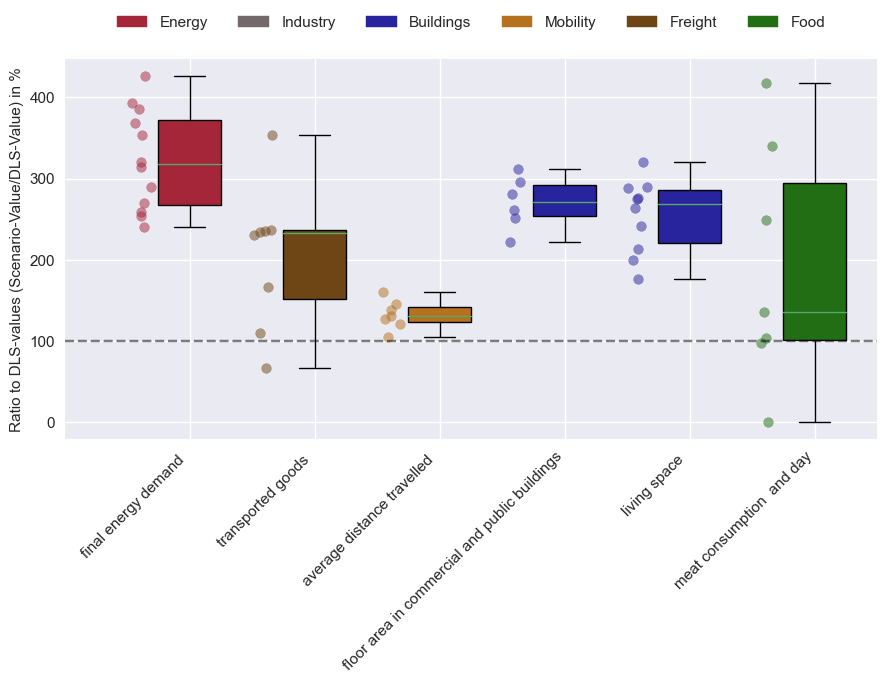

In [24]:
# Makes a boxplot showing the relative difference of scenario values to the dls values
def make_boxplot_dls(data, filename, extension=False, standard=False, raw_data=False):
    '''
    Function to make a boxplot of the relative change to the dls values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order', 'DLS'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter'] == x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] = main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])
    main_indicators_plotting_df['DLS'] = main_indicators_plotting_df['Indicator'].apply(lambda x: get_dls(x, data))
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    main_indicators = main_indicators_plotting_df.index

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()

        if indicator in get_main_indicators(analysis_standard_df, split=True)[0]:
            indicator_data = get_values_mobility(indicator_data, indicator)

        indicator_values = indicator_data['Value']

        # Get the median
        indicator_dls = main_indicators_plotting_df.at[indicator, 'DLS']

        if pd.isnull(indicator_dls):
            continue

        # Calculate the relative change to the median
        indicator_relative = indicator_values / indicator_dls

        # Add new columns for Median and Relative Change
        indicator_data['DLS'] = indicator_dls
        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_dls
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])

        boxplot_data[indicator] = indicator_relative*100

    # Creates a results table as excel containing all the datapoints
    create_result_table_boxplot(indicator_table_data, f'{filename}_table', ['DLS', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(9, 7))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df.at[key, 'Color']
        ax.scatter(x, y, c=color, alpha=0.5)

    # fill the boxplot with colors according to the sector
    colors = [main_indicators_plotting_df.at[key, 'Color'] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # configure the plot
    ax.set_ylabel('Ratio to DLS-values (Scenario-Value/DLS-Value) in %')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)
    
    # Make a horizontal line to show the 1 line (When value is 1, no change happened)
    ax.axhline(100, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]

    # plot the legend at the top of the plot
    ax.legend(handles=patches, loc='upper center', ncols=6, bbox_to_anchor=(0.5, 1.15), bbox_transform=ax.transAxes, fontsize=11)

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches="tight")

make_boxplot_dls(analysis_df, 'boxplot_dls_fig12')



##### 3.2.3 Make Boxplot Historic

For each indicator show the differences to the historic values.

In [25]:
# Get the historic data for one main indicator and study
def get_historic(row, data):
    '''
    Function to get the historic data for one main indicator and study.
    :param row: Row of the data
    :param data: Data from the Scenario Analysis sheet
    :return: Historic value
    '''
    # Get the historic data for the indicator
    historic_data = get_historic_data(data, row['Main comparison parameter'])

    # Get the source and scope of the study
    scenario = row['Source']
    scope = row['Geographic scope']

    # Check if a historic value for négaWatt is available
    if len(historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]):
        historic_value = historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]['Value'].values[0]

    # Else check if a historic value of the scenario is available
    elif len(historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]):
        historic_value = historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
    
    # Otherwise check if a historic value of the scope is available
    elif scope in historic_data['Geographic scope'].values:
        historic_value = historic_data[historic_data['Geographic scope'] == scope]['Value'].values[0]

    # Otherwise no historic value is available
    else:
        historic_value = np.nan

    return historic_value

C:\Users\Celia\AppData\Local\Temp\ipykernel_17100\2266513727.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .transform(lambda x: np.nan if ('without active' in x.values) and (len(x.values) > 1) else x),
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


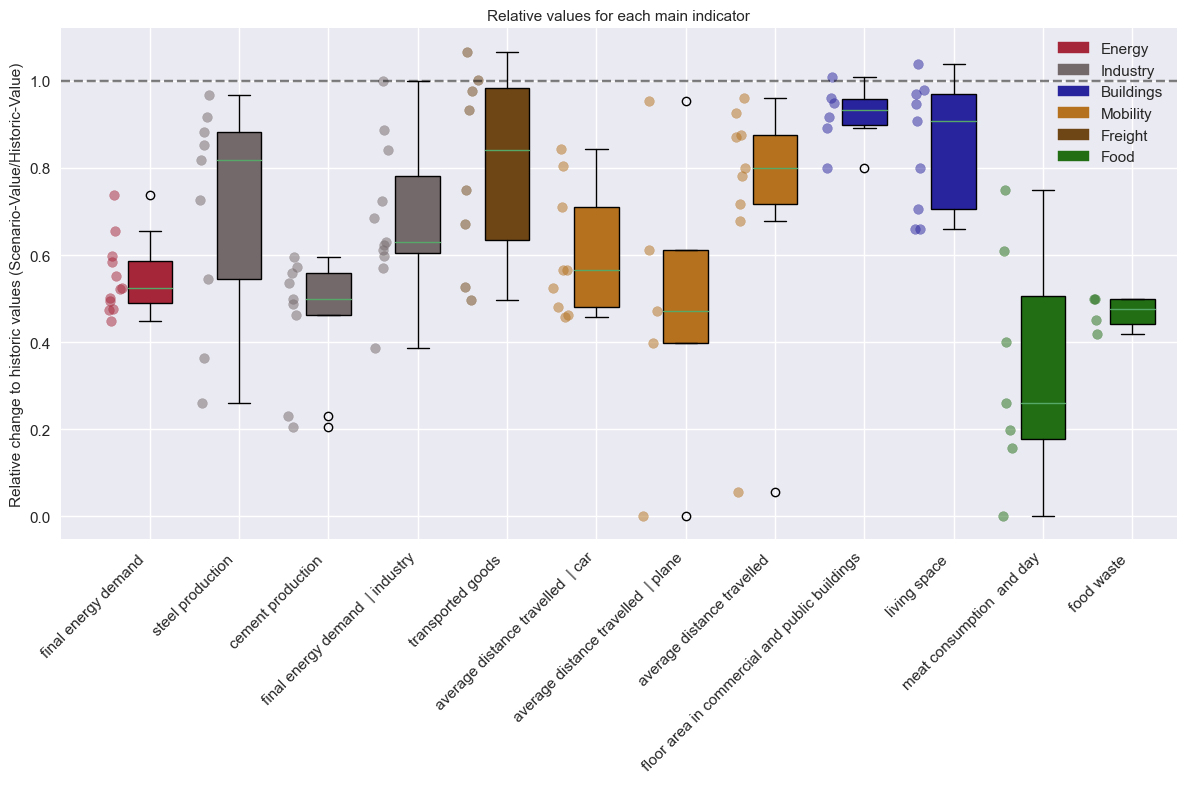

In [26]:
# Makes a boxplot showing the relative difference between each scenario and the corresponding historic value
def make_boxplot_historic(data, filename, extension = False, standard=False, raw_data=False):
    '''
    Function to make a boxplot of the relative change to the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])
    main_indicators_plotting_df = main_indicators_plotting_df.sort_values(by=['Order'])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    main_indicators = main_indicators_plotting_df.index

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    boxplot_data = {}
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator)
        indicator_data = indicator_data.dropna(subset=['Historic'])
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data['Historic'] = pd.to_numeric(indicator_data['Historic'], errors='coerce')   

        # Get the groups to only select the same groups for historic and scenario
        indicator_data = get_groups(indicator_data, indicator)
        indicator_data = indicator_data[indicator_data['Group'] == indicator_data['Historic_Group']] 

        # Get the Scenario values
        indicator_values = indicator_data['Value']

        # Get the histroic Values
        indicator_historic = indicator_data['Historic']

        # Calculate the relative change to the historic value
        indicator_relative = indicator_values / indicator_historic
        boxplot_data[indicator] = indicator_relative

        indicator_data['Relative Change'] = indicator_data['Value'] / indicator_historic
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])

    create_result_table_boxplot(indicator_table_data, f'{filename}_table', ['Historic', 'Relative Change'])

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 8))
    bplot = ax.boxplot(boxplot_data.values(), 
                    showfliers=True, 
                    patch_artist=True)

    # Add the datapoints as scatter
    for i, key in enumerate(boxplot_data.keys()):
        y = boxplot_data[key]
        x = np.random.normal(i+0.6, 0.04, size=len(y))
        color = main_indicators_plotting_df.at[key, 'Color']
        ax.scatter(x, y, c=color, alpha=0.5)

    # fill with colors according to the sector
    colors = [main_indicators_plotting_df.at[key, 'Color'] for key in boxplot_data.keys()]
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

    # Configure the plot
    ax.set_title(f'Relative values for each main indicator')
    ax.set_ylabel('Relative change to historic values (Scenario-Value/Historic-Value)')
    naming_x_axis = [s.replace('per capita and year', '').replace('per capita', '') for s in boxplot_data.keys()] 
    ax.set_xticks(np.arange(start=1, stop=len(naming_x_axis)+1), naming_x_axis, rotation=45, ha="right")
    ax.set_xlim(0)

    # Make a horizontal loine to show the 1 line (When value is 1, no change happened)
    ax.axhline(1, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]

    # plot the legend
    ax.legend(handles=patches, loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

make_boxplot_historic(analysis_df, 'boxplot_historic')

#### 3.3 Make a Dotplot for each scenario
In this step we make a dotplot showing the relative change of the scenario value to the historic value for each scenario. Therefore we firstly define the colors used for each indicator.

In [27]:
colors_indicators = {
    'average distance travelled per capita and year': '#faa200',
    'average distance travelled per capita and year | plane': '#f7c569',
    'average distance travelled per capita and year | car' : '#f0e800', 
    'transported goods per capita and year': '#6e4615',
    'final energy demand per capita and year': '#ac3939',
    'final energy demand per capita and year | industry': '#585463',
    'cement production per capita and year': '#878787',
    'steel production per capita and year': '#bdbdbd',
    'food waste per capita and year': '#58cc3e',
    'meat consumption per capita and day': '#a5ec7e',
    'per capita floor area in commercial and public buildings': '#3464a2',
    'living space per capita': '#8badda'    
}

C:\Users\Celia\AppData\Local\Temp\ipykernel_17100\2266513727.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .transform(lambda x: np.nan if ('without active' in x.values) and (len(x.values) > 1) else x),
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


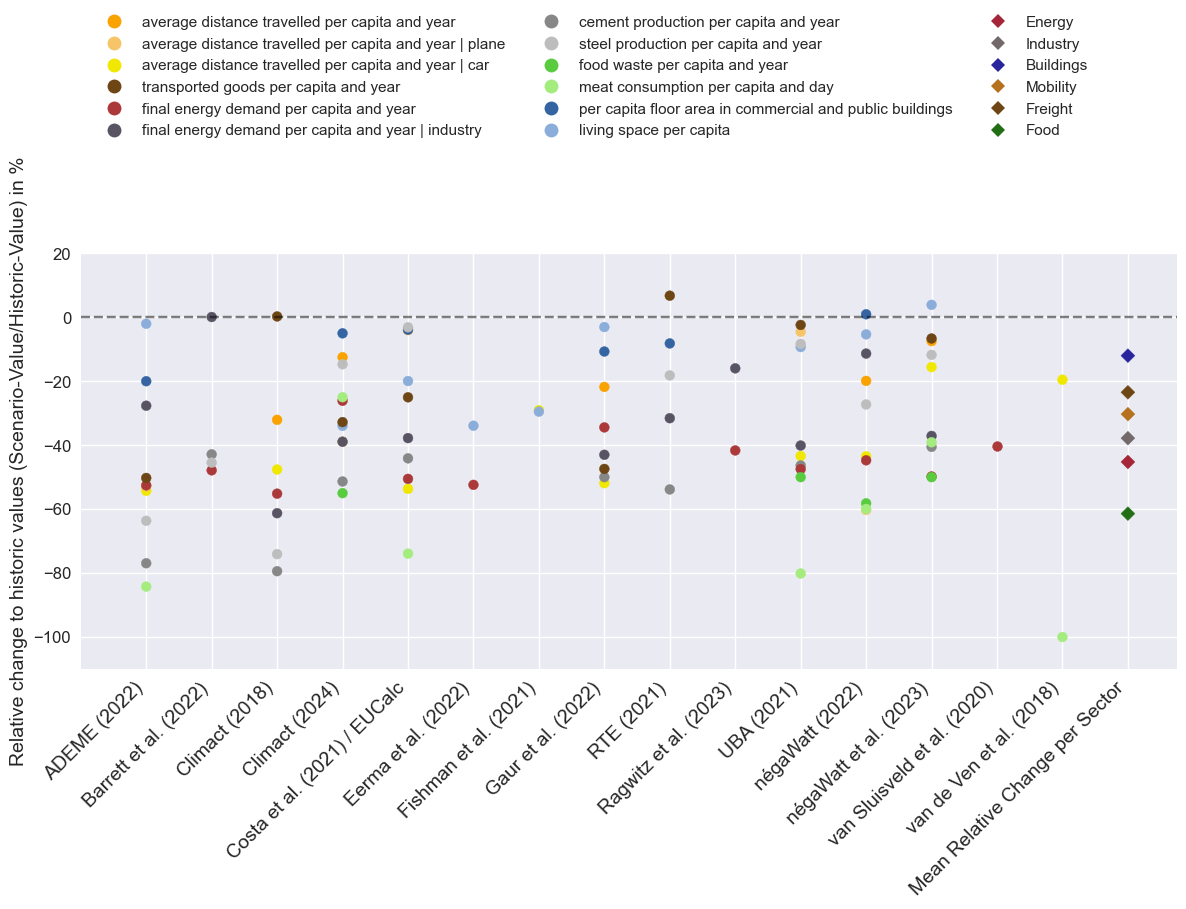

In [35]:
def make_plot_relative_change(data, filename, extension=False, standard=False, raw_data=False, color_per_sector=False):
    '''
    Function to make a boxplot of the relative change to the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):
        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        if color_per_sector:
            sector = sectors_df[sectors_df['Parameter'] == indicator]['Sector'].values[0]
            indicator_data['Sector'] = sector
            indicator_data['Color'] = colors_sector[sector]
        else:
            indicator_data['Color'] = colors_indicators[indicator]
        
        # Get the historic values
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator)
        indicator_data = indicator_data.dropna(subset=['Historic'])
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data['Historic'] = pd.to_numeric(indicator_data['Historic'], errors='coerce')    

        # Get the groups to only select the same groups for historic and scenario
        indicator_data = get_groups(indicator_data, indicator)
        indicator_data = indicator_data[indicator_data['Group'] == indicator_data['Historic_Group']]

        # Get the scenario values and relative change
        indicator_data['Relative Change'] = ((indicator_data['Value'] - indicator_data['Historic']) / indicator_data['Historic']) * 100
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])
    
    # Only keep the maximum value for each scenario and main comparison parameter pair
    indicator_table_data_max = indicator_table_data.loc[indicator_table_data.groupby(['Source', 'Main comparison parameter'])['Relative Change'].idxmax()]

    # Creates a results table as excel containing all the datapoints
    create_result_table_boxplot(indicator_table_data_max, f'{filename}_table', ['Historic', 'Relative Change'])

    # Get all scenarios
    scenarios = indicator_table_data_max['Source'].unique()

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12, 9))

    update_font_sizes(small_size=14, medium_size=14, big_size=14)

    # Add the datapoints as scatter for each scenario
    for i, scenario in enumerate(scenarios):
        values = indicator_table_data_max[indicator_table_data_max['Source'] == scenario]['Relative Change']
        x = np.random.normal(i + 1, 0.08, size=len(values))
        color = indicator_table_data_max[indicator_table_data_max['Source'] == scenario]['Color']
        ax.scatter([i + 1] * len(values), values, c=color, alpha=1, s=50)

    # Plot a diamond for the mean value of each sector
    sector_means = indicator_table_data_max.groupby('Sector', as_index=False).agg({'Relative Change': 'mean'})
    sector_means['Color'] = sector_means['Sector'].apply(lambda x: colors_sector[x])
    ax.scatter([len(scenarios) + 1] * len(sector_means), sector_means['Relative Change'], c=sector_means['Color'], alpha=1, s=50, marker='D')

    # Configure the plot
    ax.set_ylabel('Relative change to historic values (Scenario-Value/Historic-Value) in %', fontsize=14)
    x_ticks = np.append(scenarios, 'Mean Relative Change per Sector')
    ax.set_xticks(np.arange(start=1, stop=len(scenarios) + 2), x_ticks, rotation=45, ha="right", fontsize=14)
    ax.tick_params(axis='y', labelleft=True, labelright=False)
    ax.set_xlim(0)
    ax.set_ylim(-110, 20)

    # Make a horizontal line to show the 1 line (When value is 1, no change happened)
    ax.axhline(0, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    if color_per_sector:
        patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]
    else:
        patches_scenarios = [plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=colors_indicators[x],
                                      label="{:s}".format(x))[0] for x in colors_indicators.keys()]

        patches_sectors = [plt.plot([], [], marker="D", ms=7, ls="", mec=None, color=colors_sector[x],
                                    label="{:s}".format(x))[0] for x in colors_sector.keys()]

        patches = patches_scenarios + patches_sectors
    # plot the legend
    ax.legend(handles=patches, loc='upper center', ncols=3, bbox_to_anchor=(-0.1, 0, 1.2, 1.015),
              bbox_transform=plt.gcf().transFigure, fontsize=11)

    # Save figure either with default extension or with extension given in the function
    plt.savefig(f'figures/{filename}.png')  # , bbox_inches = "tight")
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}')  # , bbox_inches = "tight")
    
    # Reset Font Sizes
    update_font_sizes()

# Call the modified function
make_plot_relative_change(analysis_df, 'dotplot_studies_historic_change_fig11', color_per_sector=False)


                           Source Geographic scope   
172                  ADEME (2022)               FR  \
858  Costa et al. (2021) / EUCalc          EU28+CH   
404                Climact (2018)             EU28   
94          Fishman et al. (2021)               DE   
3              Gaur et al. (2022)               IE   
32                négaWatt (2022)               FR   
545        négaWatt et al. (2023)             EU27   
116                    UBA (2021)               DE   
387      van de Ven et al. (2018)             EU27   

                        Source+geogr. scope Scenario (name/historic/DLS)   
172                       ADEME (2022) - FR           S1: Low production  \
858  Costa et al. (2021) / EUCalc - EU28+CH               Life / Lever 4   
404                   Climact (2018) - EU28                       demand   
94               Fishman et al. (2021) - DE                 based on LED   
3                   Gaur et al. (2022) - IE                         ILED   
32 

C:\Users\Celia\AppData\Local\Temp\ipykernel_17100\2266513727.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .transform(lambda x: np.nan if ('without active' in x.values) and (len(x.values) > 1) else x),


                           Source Geographic scope   
172                  ADEME (2022)               FR  \
858  Costa et al. (2021) / EUCalc          EU28+CH   
404                Climact (2018)             EU28   
94          Fishman et al. (2021)               DE   
3              Gaur et al. (2022)               IE   
32                négaWatt (2022)               FR   
545        négaWatt et al. (2023)             EU27   
116                    UBA (2021)               DE   
387      van de Ven et al. (2018)             EU27   
177                  ADEME (2022)               FR   
804                Climact (2024)             EU27   
29                négaWatt (2022)               FR   
122                    UBA (2021)               DE   
123                    UBA (2021)               DE   
800                Climact (2024)             EU27   
802                Climact (2024)             EU27   
806                Climact (2024)             EU27   
857  Costa et al. (2021) / E

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


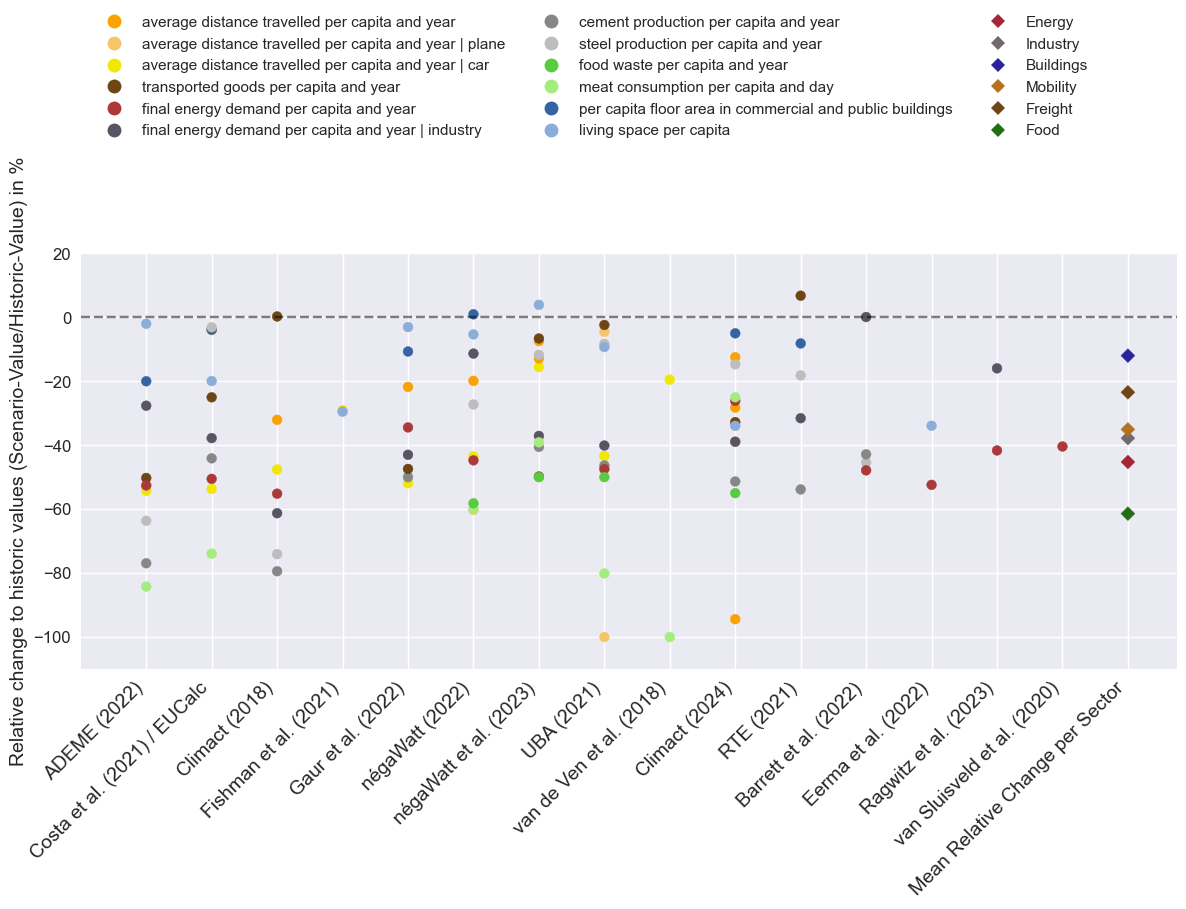

In [29]:
# Makes a boxplot showing the relative difference between each scenario and the corresponding historic value
def make_plot_relative_change(data, filename, extension = False, standard=False, raw_data=False, color_per_sector=False):
    '''
    Function to make a boxplot of the relative change to the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :param raw_data: Boolean if the raw data should be used instead of the filtered data
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data
        data = raw_data

    # Get the main indicators
    main_indicators = get_main_indicators(analysis_standard_df)

    # Make a boxplot per Indicator
    # Calculate the Median for each Indicator and then the Percentage difference
    indicator_table_data = pd.DataFrame()

    # Iterate over the indicators and calculate the median and the difference to it
    for i, indicator in enumerate(main_indicators):

        # get the data for the current indicator
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        if color_per_sector:
            sector = sectors_df[sectors_df['Parameter']==indicator]['Sector'].values[0]
            indicator_data['Sector'] =  sector
            indicator_data['Color'] = colors_sector[sector]
        else:
            indicator_data['Color'] = colors_indicators[indicator]
        
        # Get the historic values
        indicator_data = get_historic_values(analysis_df, indicator_data, indicator)
        indicator_data = indicator_data.dropna(subset=['Historic'])
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        indicator_data['Historic'] = pd.to_numeric(indicator_data['Historic'], errors='coerce')    

        # Get the groups to only select the same groups for historic and scenario
        indicator_data = get_groups(indicator_data, indicator)
        indicator_data = indicator_data[indicator_data['Group'] == indicator_data['Historic_Group']]

        # Get the scenario values
        indicator_values = indicator_data['Value']

        # Get the histroic Values
        indicator_historic = indicator_data['Historic']

        indicator_data['Relative Change'] = ((indicator_data['Value'] - indicator_historic) / indicator_historic) *100
        indicator_table_data = pd.concat([indicator_table_data, indicator_data])
        print(indicator_table_data)
    # Creates a results table as excel containing all the datapoints
    create_result_table_boxplot(indicator_table_data, f'{filename}_table', ['Historic', 'Relative Change'])

    # Get all scenarios
    scenarios = indicator_table_data['Source'].unique()

    # Make a boxplot for the indicator values
    fig, ax = plt.subplots(1, figsize=(12,9))

    update_font_sizes(small_size=14, medium_size=14, big_size=14)

    # Add the datapoints as scatter for each scenario
    for i, scenario in enumerate(scenarios):
        values = indicator_table_data[indicator_table_data['Source'] == scenario]['Relative Change']
        x = np.random.normal(i+1, 0.08, size=len(values))
        color = indicator_table_data[indicator_table_data['Source'] == scenario]['Color']
        ax.scatter([i+1]*len(values), values, c=color, alpha=1, s=50)

    # Plot a diamond for the mean value of each sector
    sector_means = indicator_table_data.groupby('Sector', as_index=False).agg({'Relative Change':'mean'})
    sector_means['Color'] = sector_means['Sector'].apply(lambda x: colors_sector[x])
    ax.scatter([len(scenarios)+1]*len(sector_means), sector_means['Relative Change'], c=sector_means['Color'], alpha=1, s=50, marker='D')

    # Configure the plot
    #ax.set_title(f'Relative changes for each scenario and indicator')
    ax.set_ylabel('Relative change to historic values (Scenario-Value/Historic-Value) in %', fontsize = 14)
    x_ticks = np.append(scenarios, 'Mean Relative Change per Sector')
    ax.set_xticks(np.arange(start=1, stop=len(scenarios)+2), x_ticks , rotation=45, ha="right", fontsize = 14)
    ax.tick_params(axis='y', labelleft=True, labelright=False)
    ax.set_xlim(0)
    ax.set_ylim(-110, 20)

    # Make a horizontal loine to show the 1 line (When value is 1, no change happened)
    ax.axhline(0, color='#030303', linestyle='--', alpha=0.5)

    # manually define a new patch 
    if color_per_sector:
        patches = [mpatches.Patch(color=colors_sector[x], label=x) for x in colors_sector.keys()]
    else:
        patches_scenarios = [plt.plot([],[], marker="o", ms=10, ls="", mec=None, color=colors_indicators[x], 
            label="{:s}".format(x) )[0]  for x in colors_indicators.keys()]
        
        patches_sectors = [plt.plot([],[], marker="D", ms=7, ls="", mec=None, color=colors_sector[x], 
            label="{:s}".format(x) )[0]  for x in colors_sector.keys()]
        
        patches = patches_scenarios + patches_sectors
    # plot the legend
    ax.legend(handles=patches, loc='upper center', ncols = 3, bbox_to_anchor = (-0.1, 0, 1.2, 1.015),
            bbox_transform = plt.gcf().transFigure, fontsize = 11)

    # Save figure either with default extension or with extension given in the function
    plt.savefig(f'figures/{filename}.png') #, bbox_inches = "tight")
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}') #, bbox_inches = "tight")
    
    #plt.tight_layout()

make_plot_relative_change(analysis_df, 'dotplot_studies_historic_change', color_per_sector=False)

# Reset Font Sizes
update_font_sizes()

### 4. Additional Plots

Make additional Plots not used in the puplished Paper.

#### 4.1 Occurences Plot

This plot shows for each indicator how many studies are available

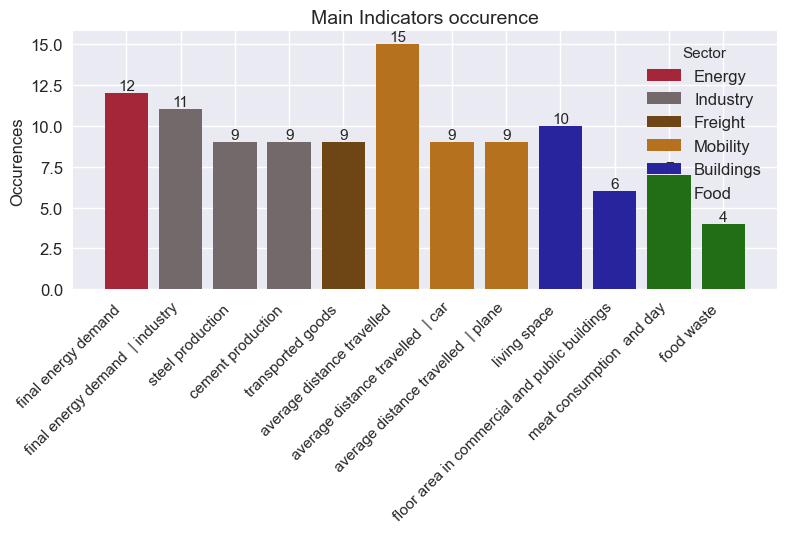

In [30]:
# Define it as a function to make it reusable
def make_barplot_occurences(data, filename, extension=False, standard=False):
    '''
    Function to make a barplot of the occurences of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    # Check for the boolean standard, which indicates if the given data is already filtered after standard scenarios or if it has to be done
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    # Get the main indicators excluding the mobility ones
    main_indicators = get_main_indicators(analysis_standard_df)
    
    # Get counts per Main Indicator
    main_indicator_count = analysis_standard_df['Main comparison parameter'].value_counts()

    # Create Dataframe for plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Occurences', 'Sector', 'Color'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Occurences'] = main_indicators_plotting_df['Indicator']\
                                                    .apply(lambda x: main_indicator_count.loc[x])
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator']\
                                                    .apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector']\
                                                    .values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector']\
                                                    .apply(lambda x: colors_sector[x])
    main_indicators_plotting_df['Order'] =  main_indicators_plotting_df['Sector'].apply(lambda x: order_sectors[x])

    # Sort the Values by the Order and the Occurences
    main_indicators_plotting_df = main_indicators_plotting_df\
                                    .sort_values(by=['Order', 'Occurences'], ascending=[True, False])

    # Make a bar plot
    fig, ax = plt.subplots(1)
    bar = ax.bar(main_indicators_plotting_df['Indicator'].values, 
                main_indicators_plotting_df['Occurences'].values, 
                label=main_indicators_plotting_df['Sector'].values, 
                color=main_indicators_plotting_df['Color'].values)
    
    # Configure the plot
    ax.set_title('Main Indicators occurence')
    ax.set_ylabel('Occurences')
    ax.bar_label(bar)
    
    # Remove the per capita out of the naming to save space
    main_indicators_x_axis_naming = [s.replace('per capita and year', '')\
                                     .replace('per capita', '') for s in main_indicators_plotting_df['Indicator'].values] 
    
    # Set the xticks
    ax.set_xticks(np.arange(len(main_indicators_plotting_df['Indicator'].values)), 
                labels=main_indicators_x_axis_naming, 
                rotation=45, 
                ha="right")
    
    # Get the correct legend without duplicate keys
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), title='Sector', loc='upper right')

    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = "tight")

# Call function. Extension can be set to png, eps, pdf. If nothing given the Extension defined above as default is used
make_barplot_occurences(analysis_df, 'barplot_occurences')

#### 4.2 Make a scatter plot

This plot shows for each indicator a scatter plot, where the scenario valus is shown over the historic value.

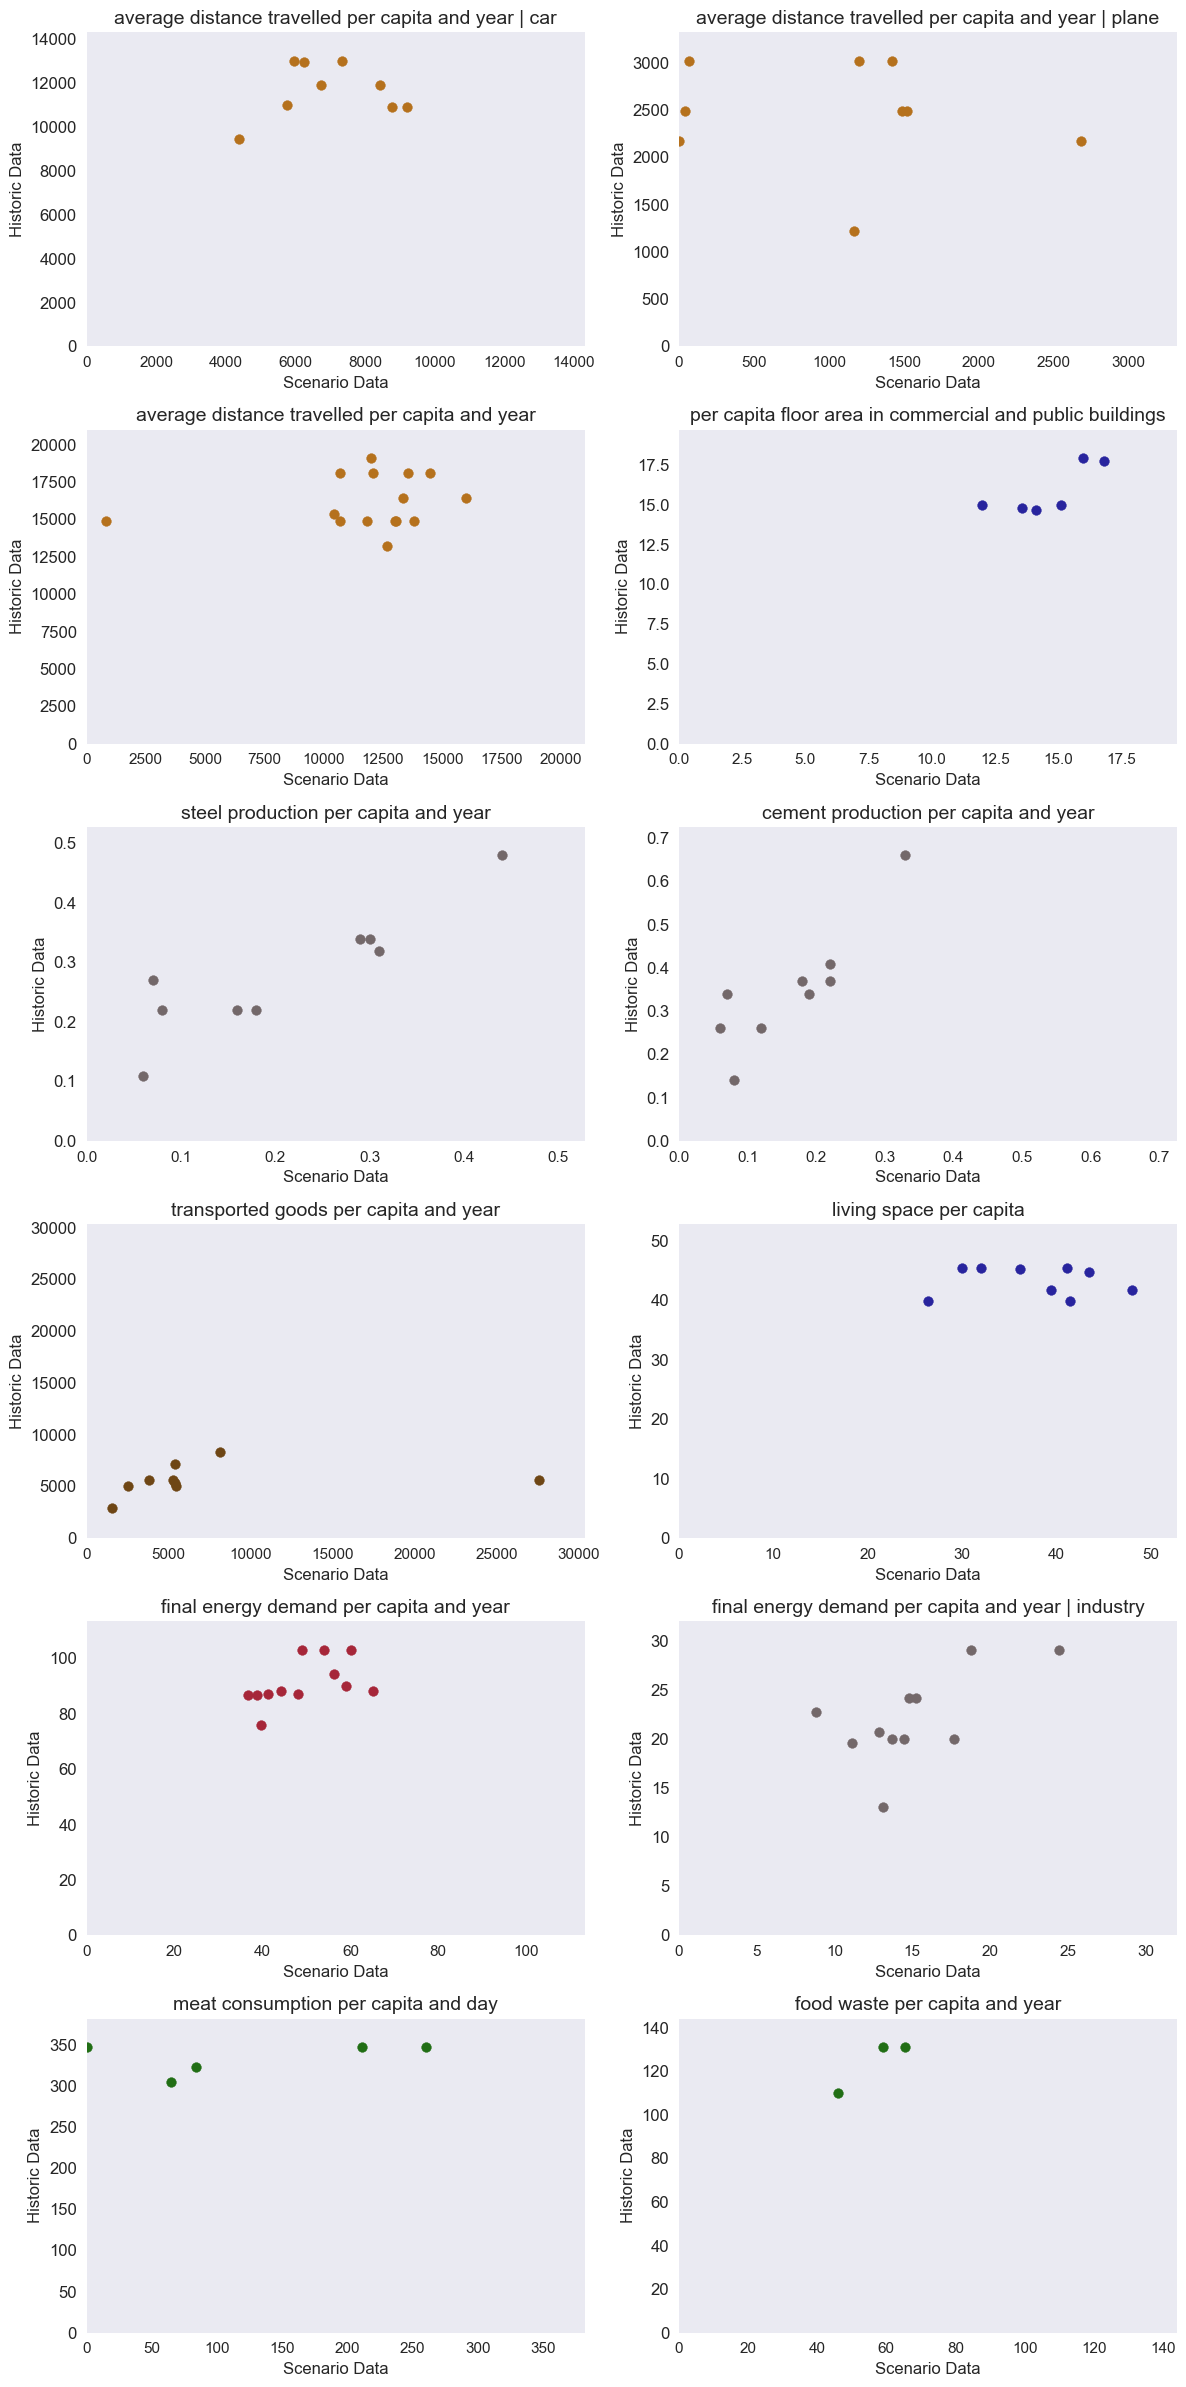

In [31]:
# Makes a scatter plot per indicator showing the scenario value over the historic value
def make_scatter_plot(data, filename, extension = False, standard=False):
    '''
    Function to make a scatter plot of the scenario values over the historic values of the main indicators.
    :param data: Data from the Scenario Analysis sheet
    :param filename: Filename of the plot
    :param extension: Extension of file to be exported
    :param standard: Boolean if the data is already filtered after standard scenarios or if it has to be done
    :return: None
    '''
    if not standard:
        analysis_standard_df = get_standard_scenarios(data, scenarios_df)
    else:
        analysis_standard_df = data

    main_indicators = get_main_indicators(analysis_standard_df)

    historic_data = get_historic_data(data)

    # Create Dataframe for the plotting
    main_indicators_plotting_df = pd.DataFrame(columns=['Indicator', 'Sector', 'Color', 'Order', 'DLS'])
    main_indicators_plotting_df['Indicator'] = main_indicators
    main_indicators_plotting_df['Sector'] =  main_indicators_plotting_df['Indicator'].apply(lambda x: sectors_df[sectors_df['Parameter']==x]['Sector'].values[0])
    main_indicators_plotting_df['Color'] = main_indicators_plotting_df['Sector'].apply(lambda x: colors_sector[x])
    main_indicators_plotting_df = main_indicators_plotting_df.set_index('Indicator')
    # Define number of columns for the subplots
    cols = 2
    rows = len(main_indicators) // cols

    # Create a figure of subplots
    fig, axs = plt.subplots(rows, cols, figsize=(12,24))

    # Iterate over the indicators and make a plot for each índicator
    for i, indicator in enumerate(main_indicators):
        
        # Calculate current row and column 
        row = i // cols
        col = i % cols
        ax = axs[row, col]

        # Get indicator data
        indicator_data = analysis_standard_df[analysis_standard_df['Main comparison parameter'] == indicator].copy()
        indicator_data['Value'] = pd.to_numeric(indicator_data['Value'], errors='coerce')
        # indicator_data['Color'] = indicator_data['Geographic scope'].apply(lambda x: scope_colors[x] if x in scope_colors.keys() else scope_colors['single'])
        # indicator_data['Label'] = indicator_data['Geographic scope'].apply(lambda x: x if x in scope_colors.keys() else 'single')
        indicator_data = indicator_data.sort_values('Value')

        # Get the sector of the indicator
        sector = main_indicators_plotting_df.at[indicator, 'Sector']

        # Get the historic data
        historic_data = get_historic_data(analysis_df, indicator)
        historic_plots = []
        drop_indices = []
        # Get for each scenario the corresponding historic value
        for index, row in indicator_data.iterrows():
            scenario = row['Source']
            scope = row['Geographic scope']
            # Check if a historic value for négaWatt is available
            if len(historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]):
                historic_value = historic_data[(historic_data['Source'] == 'négaWatt et al. (2023)') & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
                historic_plots.append(historic_value)

            # Else check if a historic value of the scenario is available
            elif len(historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]):
                historic_value = historic_data[(historic_data['Source'] == scenario) & (historic_data['Geographic scope'] == scope)]['Value'].values[0]
                historic_plots.append(historic_value)     

            # Otherwise check if a historic value of the scope is available
            elif scope in historic_data['Geographic scope'].values:
                historic_value = historic_data[historic_data['Geographic scope'] == scope]['Value'].values[0]
                historic_plots.append(historic_value)
            
            # Otherwise no historic value is available
            else:
                drop_indices.append(index)
            
        # Drop rows where no historic value exists
        indicator_data = indicator_data.drop(index=drop_indices)

        # Get values for plotting
        scenario_values = indicator_data['Value'].values
        
        # Convert to numeric
        historic_values = pd.to_numeric(historic_plots)
        
        # Get the maximum value for the plot
        if len(scenario_values) != 0:
            max_value = max(max(scenario_values), max(historic_values))
        else:
            max_value = 1

        # Plot the scatter plot
        ax.scatter(scenario_values, historic_values, color=colors_sector[sector])

        # configure plot
        ax.set_title(indicator)
        ax.set_xlabel('Scenario Data')
        ax.set_ylabel('Historic Data')
        ax.set_ylim(0, max_value*1.1)
        ax.set_xlim(0, max_value*1.1)

        # Add a grid
        ax.grid()
    
    # Make a nicer look
    plt.tight_layout()
    
    # Save figure either with default extension or with extension given in the function
    if extension:
        filename = f'{filename}.{extension}'
    plt.savefig(f'figures/{filename}', bbox_inches = 'tight')

make_scatter_plot(analysis_df, 'scatterplot')      

#### 4.3 Germany specific plots

Make all the plots from before for the studies where the scope is only Germany.

##### 4.3.1 Get German data
First we select the data where the scope is germany. Then we use the functions from before to create plots for Germany.

In [32]:
# Filter for standard scenarios
standard_scenarios = scenarios_df[scenarios_df['comparison germany'] == 1]

# Get the data for the standard scenarios for Germany
standard_scenarios_data = standard_scenarios.apply(lambda x: analysis_df[(analysis_df['Source'] == x['Source']) \
                                                                        & (analysis_df['Scenario (name/historic/DLS)'] == x['Scenario name']) \
                                                                        & (analysis_df['Geographic scope'] == 'DE')].index.values, axis=1).explode().dropna()
scenario_analysis_germany_df = analysis_df.loc[standard_scenarios_data]
scenario_analysis_germany_df['Geographic scope'] = scenario_analysis_germany_df['Geographic scope'].str.replace(' ', '')

# Filter for coding 1
scenario_analysis_germany_df = scenario_analysis_germany_df[scenario_analysis_germany_df['Coding'] == 1]

# Remove kcal Data
scenario_analysis_germany_df = scenario_analysis_germany_df[~scenario_analysis_germany_df['Unit'].str.contains('kcal')]

##### 4.3.2 Make the plots for Germany
We make use of the functions defined above to make the plots for Germany

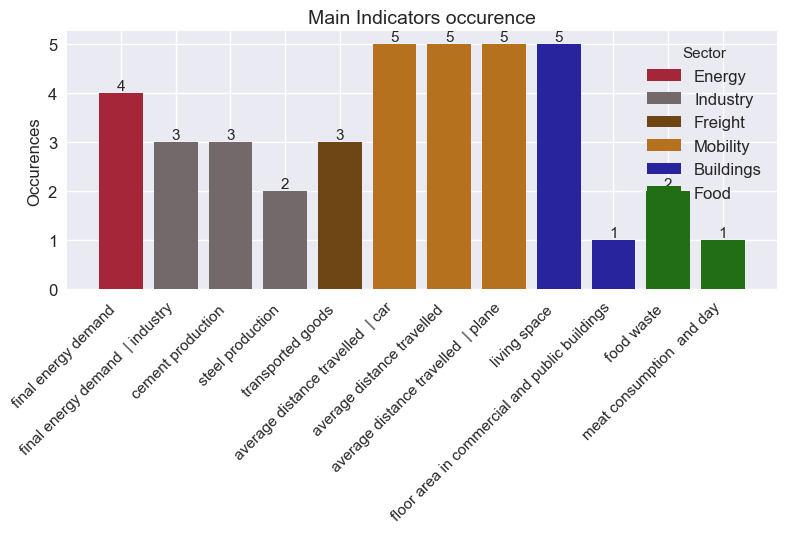

In [33]:
make_barplot_occurences(scenario_analysis_germany_df, 'barplot_occurences_germany', standard=True)

C:\Users\Celia\AppData\Local\Temp\ipykernel_17100\3099145143.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_standard_df['Sector'] =  analysis_standard_df['Main comparison parameter']\


UnboundLocalError: cannot access local variable 'add_data' where it is not associated with a value

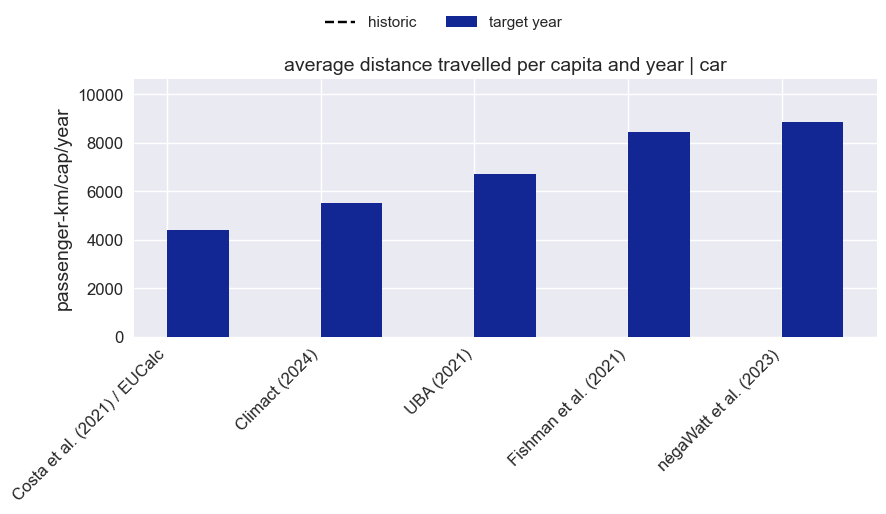

In [34]:
make_barplot_multiple(scenario_analysis_germany_df, 'barplot_values_germany', 
                      standard=True, show_extra_bars=False, show_scope = False, show_historic=False)

C:\Users\Celia\AppData\Local\Temp\ipykernel_26168\563582667.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .transform(lambda x: np.nan if ('without active' in x.values) and (len(x.values) > 1) else x),
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


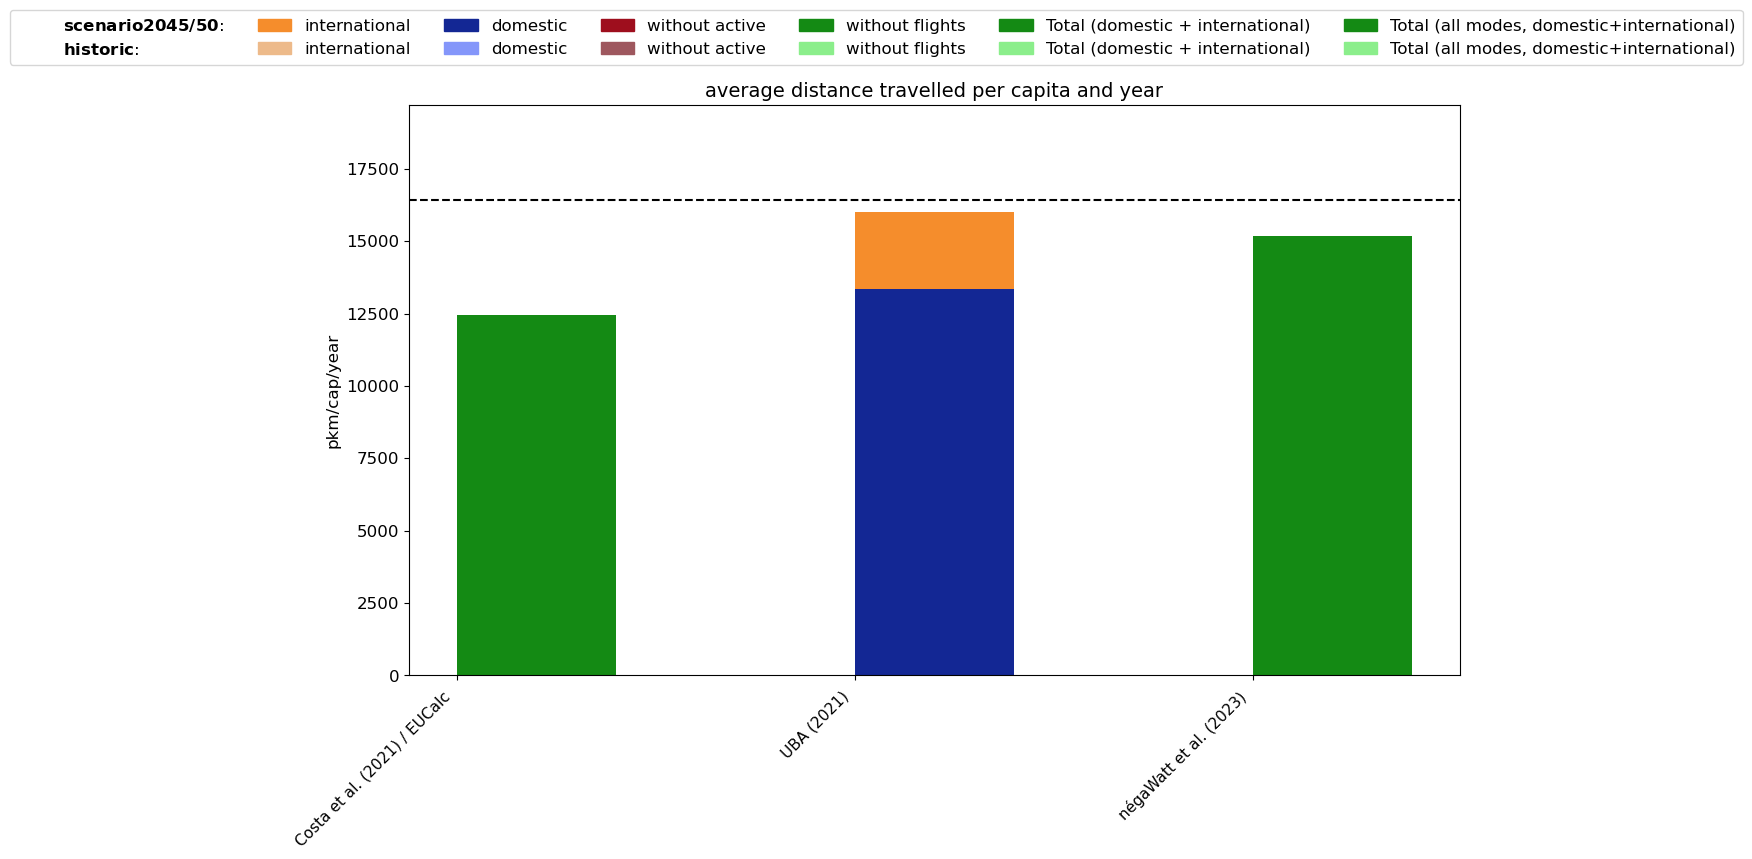

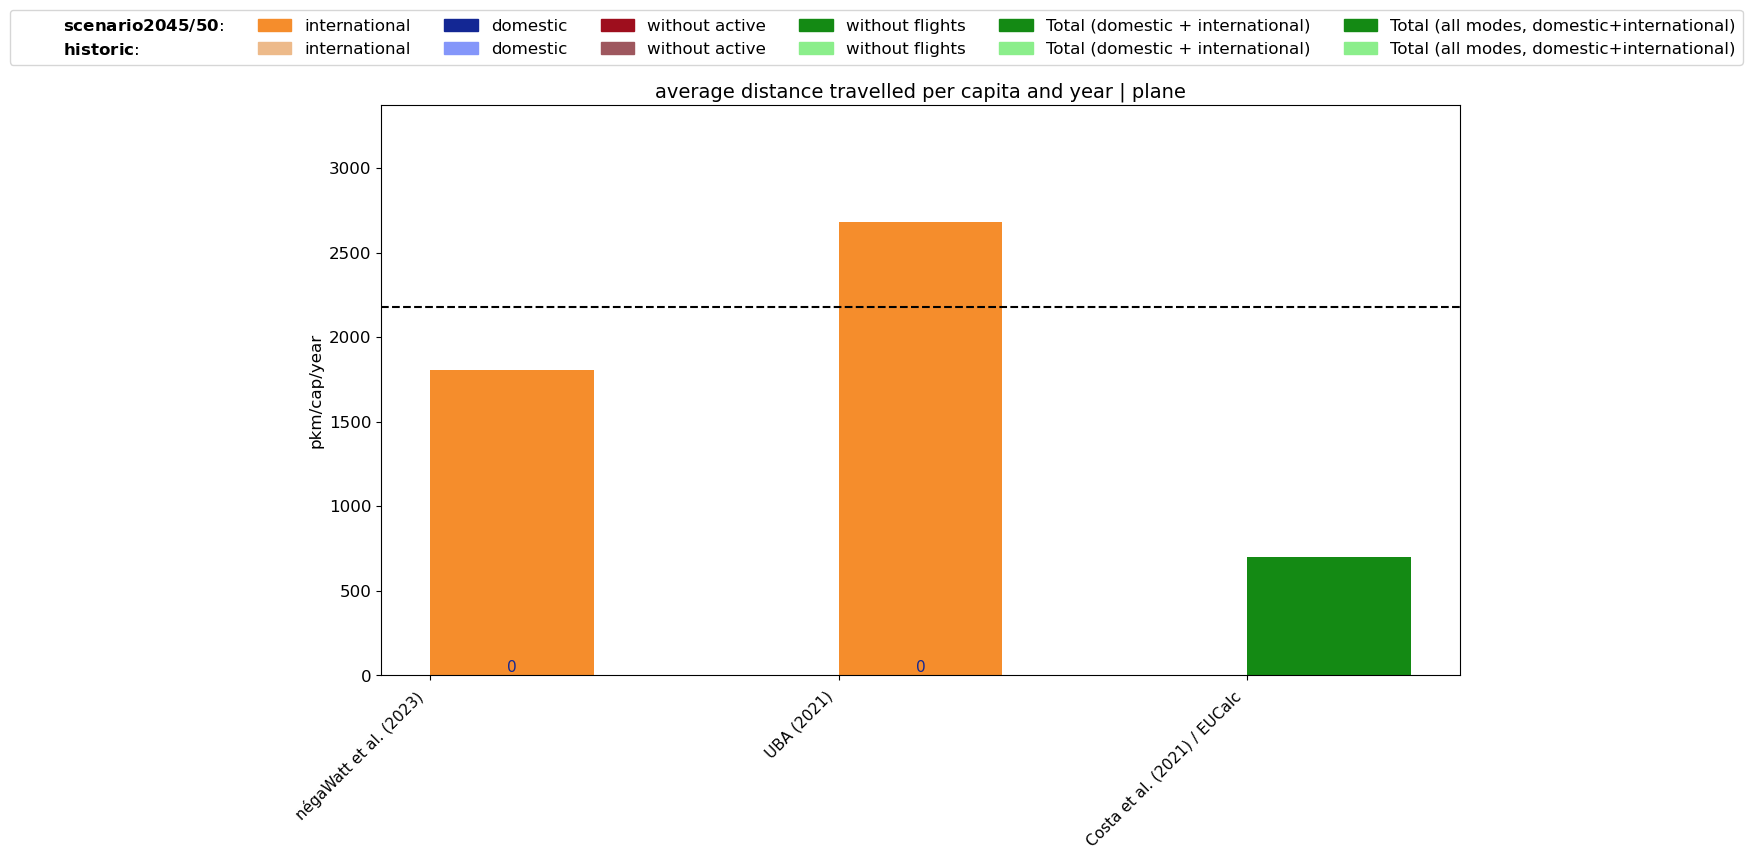

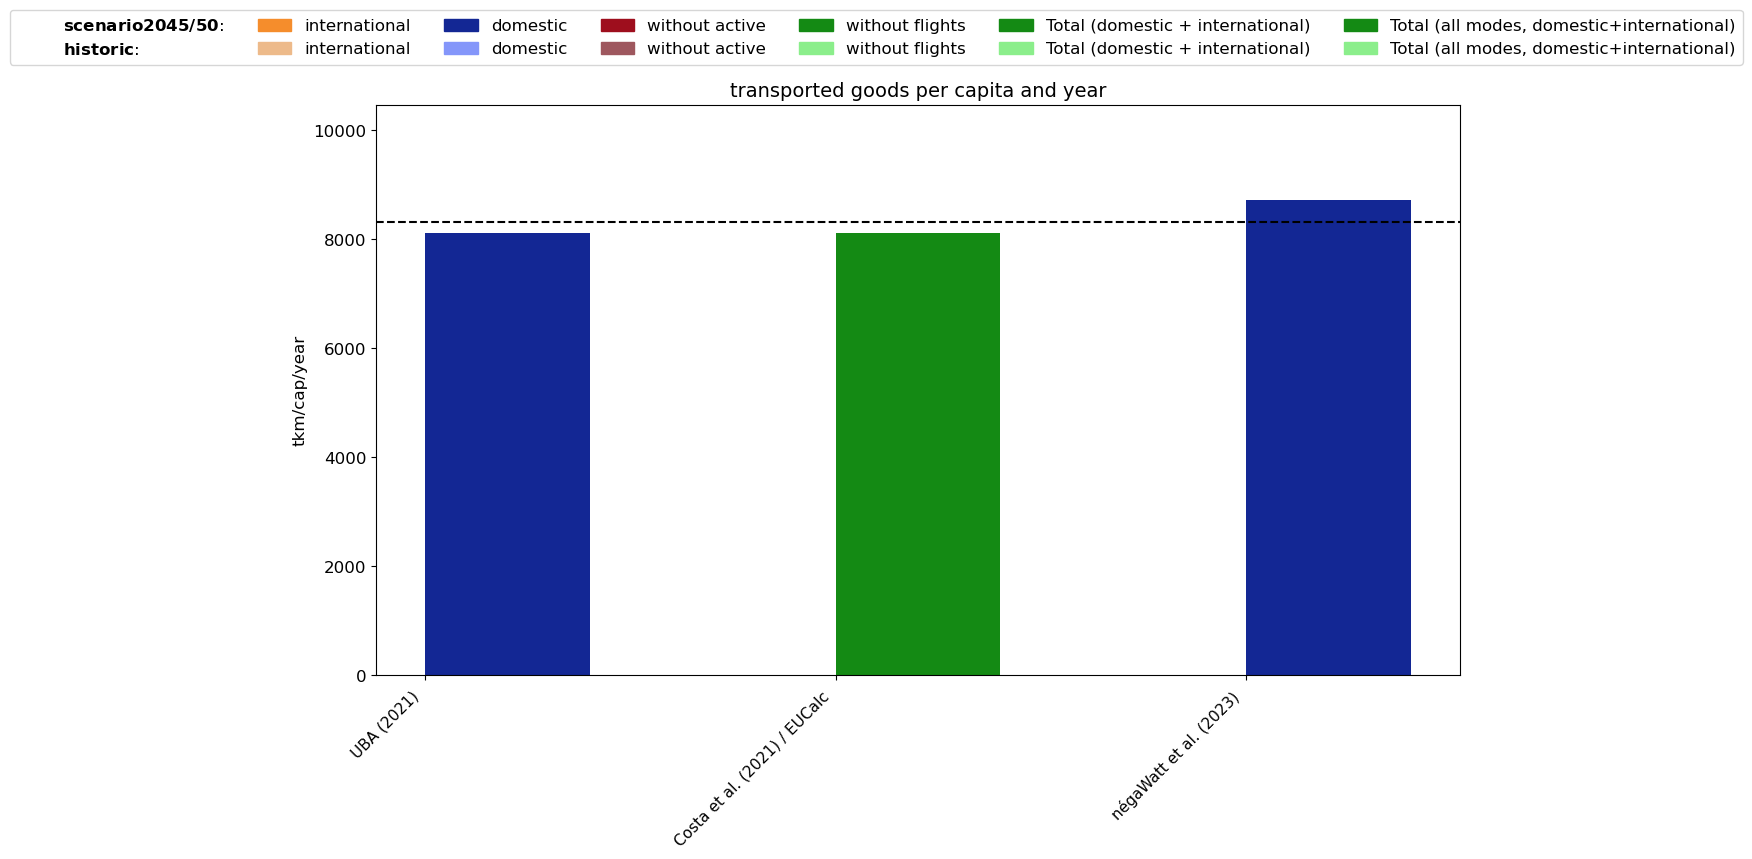

In [31]:
make_traffic_plots(scenario_analysis_germany_df, 'barplot_values_germany_mobility', 
                      standard=True, show_extra_bars=False, show_scope = False, show_historic=False)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


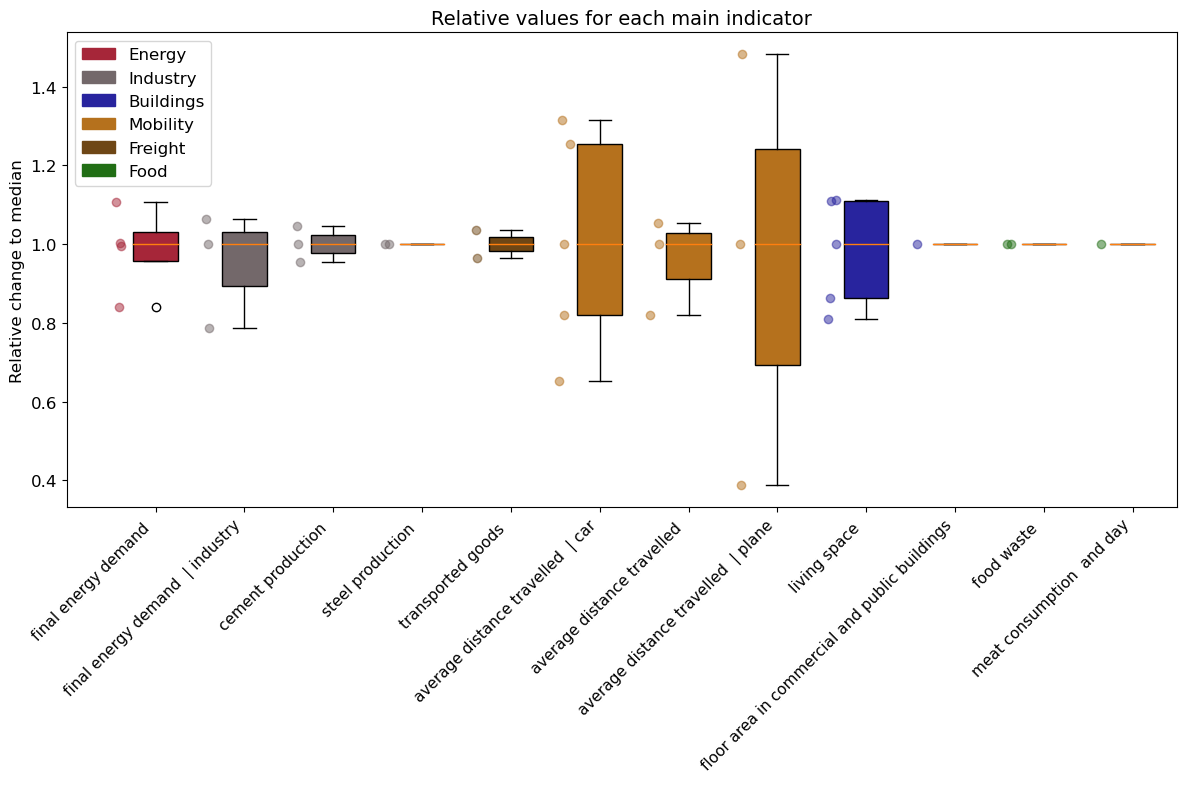

In [32]:
make_boxplot_median(scenario_analysis_germany_df, 'boxplot_germany', standard=True)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


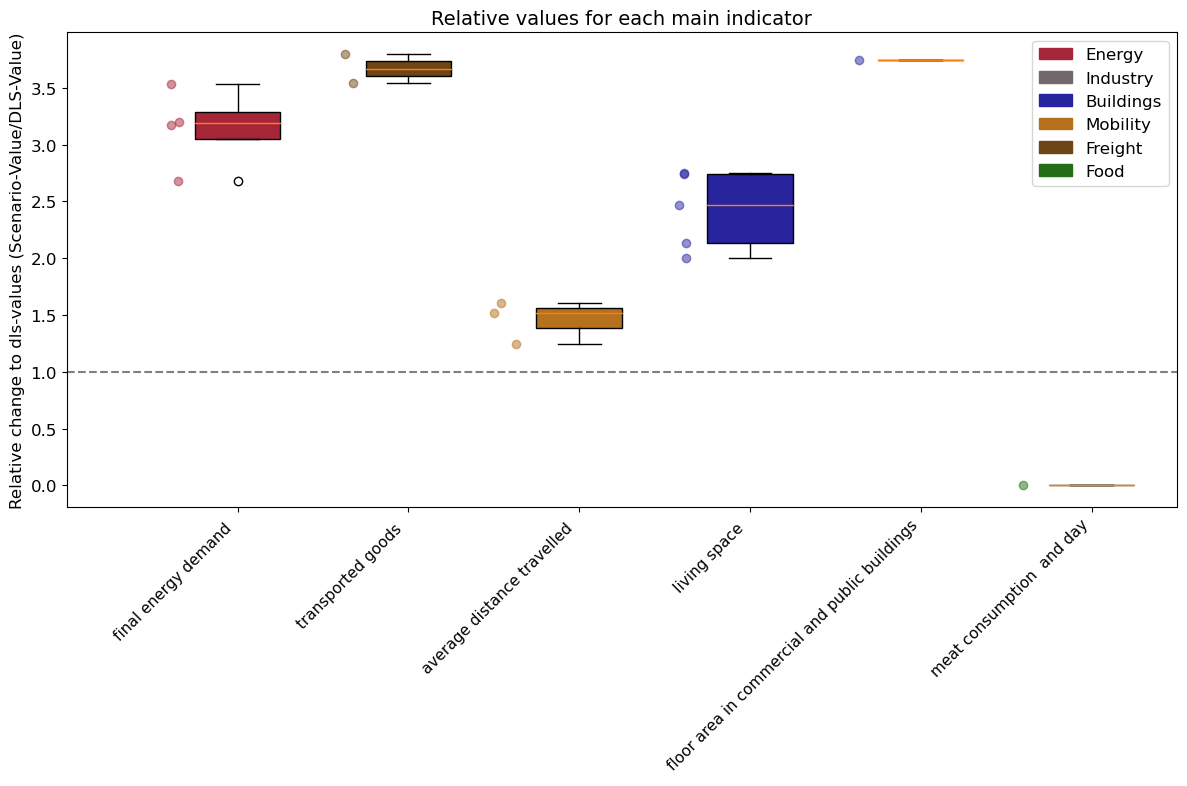

In [33]:
make_boxplot_dls(scenario_analysis_germany_df, 'boxplot_germany_dls', standard=True, raw_data=analysis_df)

C:\Users\Celia\AppData\Local\Temp\ipykernel_26168\563582667.py:57: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  .transform(lambda x: np.nan if ('without active' in x.values) and (len(x.values) > 1) else x),
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


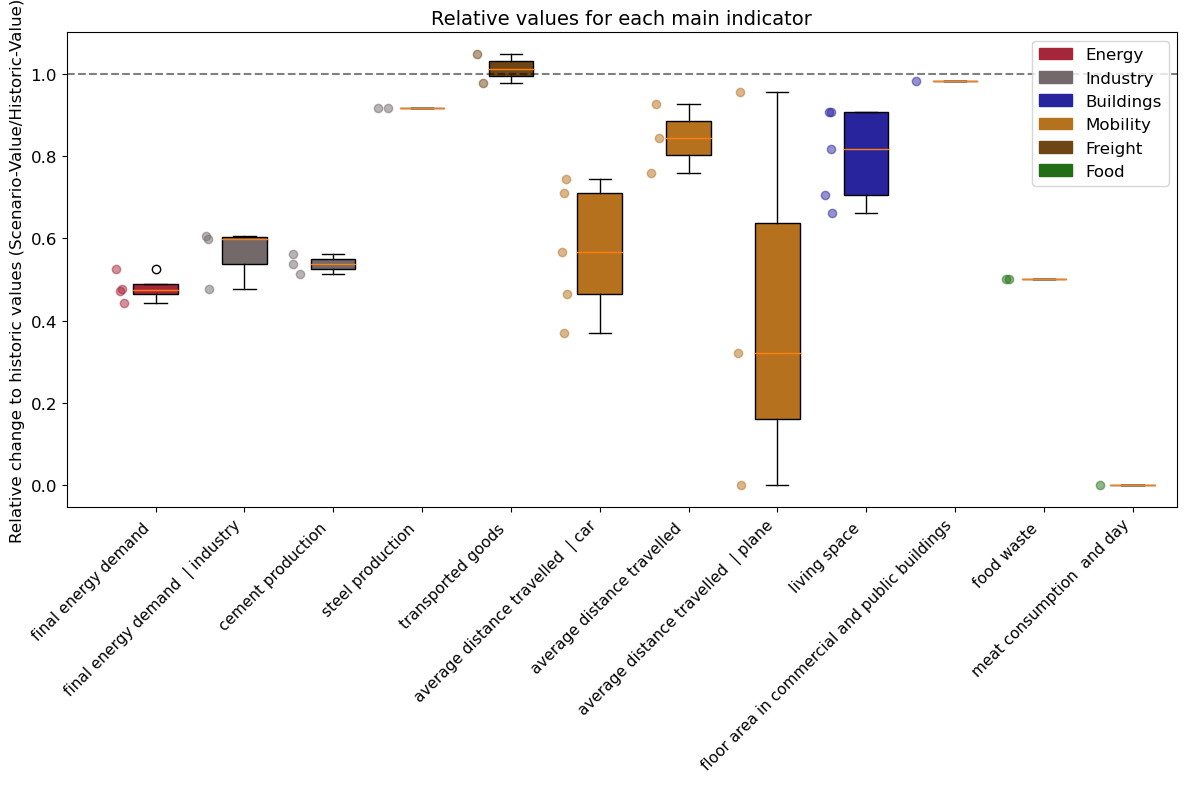

In [34]:
make_boxplot_historic(scenario_analysis_germany_df, 'boxplot_germany_historic', standard=True, raw_data=analysis_df)